In [1]:
# Movie Review Sentiment Analyzer

# This notebook demonstrates a sentiment analysis pipeline on a dataset of movie reviews.
# We apply natural language processing (NLP) techniques to classify reviews as positive or negative.

# **Key steps:**
# - Load and explore the dataset
# - Text preprocessing and feature extraction
# - Sentiment scoring with VADER
# - Model building and evaluation

# Libraries used include: `pandas`, `scikit-learn`, `NLTK`, `matplotlib`, `statsmodels`, and more.

# > Note: This notebook was originally created as part of my undergraduate coursework. The code and results are from an academic project and demonstrate foundational sentiment analysis techniques using classical tools.

In [ ]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as ticker


# 03_model-stress-tests
# Statistical analysis
import statsmodels.api as sm
from scipy.stats import skew

# NLP (Flair distilBERT and VADER lexicon installed at first use)
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# ML preprocessing
from sklearn.preprocessing import StandardScaler

In [ ]:
# READ IN CSV FILES AND MERGE
movie_info = pd.read_csv('../data/raw/movie_info.csv', index_col=0)
critic_reviews = pd.read_csv('../data/raw/CriticReviews_2018-2020.csv', index_col=0)
# Merge the two dataframes on the 'review_object_title' column
merged_df = pd.merge(movie_info, critic_reviews, on='review_object_title', how='outer', suffixes=('_movie', '_review'))

merged_df.head(100)

In [ ]:
# RENAME MovieID and MovieTitle
merged_df = merged_df.rename(columns={'Unnamed: 0': 'Movie_ID', 'review_object_title': 'Movie_Title'})

# MOVIE ID
# Reset the MovieID column to start at 1 for each unique MovieTitle
merged_df['Movie_ID'] = merged_df.groupby('Movie_Title').ngroup() + 1
#merged_df.head()

In [9]:
# create a column indicating how much of a row is missing
# Create a boolean mask indicating which cells contain Not available, NaN, or the string 'Not available'
na_mask = merged_df.isna() | merged_df.isin(['Not available'])

# Count the number of cells in each row that contain Not available, NaN, or 'Not available'
na_counts = na_mask.sum(axis=1)

# Calculate the percentage of cells in each row that contain Not available, NaN, or 'Not available'
na_percent = na_counts / len(merged_df.columns) * 100

# Add the new column to the DataFrame
merged_df['NA_Percent'] = na_percent
#merged_df

In [ ]:
# Sort the DataFrame by NA_Percent in descending order
merged_df.sort_values('NA_Percent', ascending=False)

In [ ]:
# remove rows that have more than 50% Na values. These rows don't have enough information to use useful in a sentiment analysis. 
#Also, Not available of these columns contain the important review or reviewer rating necessary for the analysis. 
merged_df = merged_df[merged_df['NA_Percent'] <= 50]
merged_df
#319 rows have been removed.

In [ ]:
# drop the NA_Percent column
merged_df = merged_df.drop('NA_Percent', axis=1)
#merged_df

# CHECK FOR NAs in columns 
# Calculate the percentage of NaN values for each column
col_na_percentage = merged_df.isna().sum() / merged_df.shape[0] * 100
# Add a new row at the top of the DataFrame with the column NaN percentages
merged_df.loc[-1] = col_na_percentage.round(2)
merged_df.index = merged_df.index + 1
merged_df = merged_df.sort_index()
merged_df.head(2)

In [ ]:
# BUDGET
# 8.12% NA
# drop duplicate column
merged_df.drop('tmdb_budget', axis=1, inplace=True)
# rename column
merged_df.rename(columns={'budget': 'Budget'}, inplace=True)
# calculate the skew of the 'Budget' column
Var_skew = skew(merged_df['Budget'].dropna())
Var_skew
# skew is 2.72 so use median to impute NA's or 0's
merged_df['Budget'] = merged_df['Budget'].replace(0, np.nan)
median_budget = merged_df['Budget'].median(skipna=True)
merged_df['Budget'] = merged_df['Budget'].fillna(median_budget)
merged_df.head(100)

In [ ]:
# RUNTIME
# 8.24% NA
# rename column
merged_df = merged_df.rename(columns={'runtime': 'Runtime'})
# calculate the skew of the 'Runtime' column
Var_skew = skew(merged_df['Runtime'].dropna())
Var_skew
# skew is 3.46 so use median to impute NA's or 0's
merged_df['Runtime'] = merged_df['Runtime'].replace(0, np.nan)
median_runtime = merged_df['Runtime'].median(skipna=True)
merged_df['Runtime'] = merged_df['Runtime'].fillna(median_runtime)
merged_df.head(100)

In [17]:
# ORIGINAL LANGUAGE
# 8.12% NA
# rename column
merged_df = merged_df.rename(columns={'original_language': 'Original_Language'})
# impute NAs with Not available
merged_df['Original_Language'] = merged_df['Original_Language'].fillna('Not available')
# rename abbreviated values with full language name
language_map = {
    'Not available': 'Not available',
    'en': 'English',
    'zh': 'Chinese',
    'sv': 'Swedish',
    'es': 'Spanish',
    'de': 'German',
    'fr': 'French',
    'xx': 'Not available',
    'it': 'Italian',
    'ka': 'Georgian',
    'cs': 'Czech',
    'fa': 'Persian',
    'ro': 'Romanian',
    'ja': 'Japanese',
    'ar': 'Arabic',
    'id': 'Indonesian',
    'hu': 'Hungarian',
    'tl': 'Tagalog',
    'pl': 'Polish',
    'sw': 'Swahili',
    'no': 'Norwegian',
    'pt': 'Portuguese',
    'he': 'Hebrew',
    'vi': 'Vietnamese',
    'hi': 'Hindi',
    'ru': 'Russian',
    'af': 'Afrikaans',
    'cn': 'Not available',
    'ko': 'Korean',
    'tr': 'Turkish',
    'az': 'Azerbaijani',
    'uk': 'Ukrainian',
    'ga': 'Irish',
    'as': 'Assamese',
    'lv': 'Latvian',
    'th': 'Thai',
    'el': 'Greek',
    'da': 'Danish',
    'nl': 'Dutch',
    'st': 'Southern Sotho',
    'ky': 'Kyrgyz',
    'fi': 'Finnish',
    'is': 'Icelandic',
    'ak': 'Akan',
    'bn': 'Bengali',
    'ml': 'Malayalam',
    'hy': 'Armenian',
    'am': 'Amharic',
    'dz': 'Dzongkha',
    'si': 'Sinhala',
    'ln': 'Lingala',
    'ur': 'Urdu',
    'mn': 'Mongolian',
    'la': 'Latin',
    'te': 'Telugu',
    'bs': 'Bosnian',
    'bg': 'Bulgarian',
    'ca': 'Catalan',
    'kk': 'Kazakh',
    'ne': 'Nepali',
    'lt': 'Lithuanian',
    'ta': 'Tamil',
    'ms': 'Malay',
    'wo': 'Wolof',
    'eu': 'Basque',
    'pa': 'Punjabi',
    'mr': 'Marathi',
    'hr': 'Croatian',
    'mk': 'Macedonian',
    'sq': 'Albanian',
    'sr': 'Serbian'
}

merged_df['Original_Language'] = merged_df['Original_Language'].map(language_map)

In [18]:
# REVENUE
# 8.12% NA
# rename column
merged_df.rename(columns={'tmdb_revenue': 'Revenue'}, inplace=True)
# calculate the skew of the 'Revenue' column
Var_skew = skew(merged_df['Revenue'].dropna())
Var_skew
# skew is 4.83 so use median to impute NA's or 0's
merged_df['Revenue'] = merged_df['Revenue'].replace(0, np.nan)
median_revenue = merged_df['Revenue'].median(skipna=True)
merged_df['Revenue'] = merged_df['Revenue'].fillna(median_revenue)
merged_df.head(100)

,Movie_Title,genres,Budget,Runtime,Original_Language,Revenue,release_date,tmdb_popularity,tmdb_vote_avg,tmdb_vote_count,...,reviewer_rating_actual,reviewer rating,tmeter,review_src_url,publication,review_object_type,review_object_year,review_object_href,critic_name,Movie_ID
0,0.0,8.91,8.12,8.24,Not available,8.12,8.36,8.120,8.12,8.12,...,33.89,100.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,#Alive,Action|Horror|Thriller|Science Fiction,35000000.00,86.00,NaN,47800000.00,7/7/2020,75.455,3.60,11.00,...,NaN,NaN,0.88,https://www.rottentomatoes.com/source-1879,1879.0,Movie,2020.0,https://www.rottentomatoes.com/m/alive_2020,Felix Vasquez Jr.,1.0
2,#Alive,Action|Horror|Thriller|Science Fiction,35000000.00,86.00,NaN,47800000.00,7/7/2020,75.455,3.60,11.00,...,4/5/2021 0:00,NaN,0.88,https://www.rottentomatoes.com/source-720,720.0,Movie,2020.0,https://www.rottentomatoes.com/m/alive_2020,John Lui,1.0
3,#Alive,Action|Horror|Thriller|Science Fiction,35000000.00,86.00,NaN,47800000.00,7/7/2020,75.455,3.60,11.00,...,3/5/2021 0:00,NaN,0.88,https://www.rottentomatoes.com/source-3784,3784.0,Movie,2020.0,https://www.rottentomatoes.com/m/alive_2020,Matt Donato,1.0
4,#Alive,Action|Horror|Thriller|Science Fiction,35000000.00,86.00,NaN,47800000.00,7/7/2020,75.455,3.60,11.00,...,NaN,NaN,0.88,https://www.rottentomatoes.com/source-2715,2715.0,Movie,2020.0,https://www.rottentomatoes.com/m/alive_2020,Scott Weinberg,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,12 Hour Shift,Thriller|Horror|Comedy|Crime,35000000.00,86.00,NaN,47800000.00,10/2/2020,85.685,5.20,84.00,...,2.5/4,NaN,0.76,https://www.rottentomatoes.com/source-2586,2586.0,Movie,2020.0,https://www.rottentomatoes.com/m/12_hour_shift,Joey Magidson,23.0
97,12 Hour Shift,Thriller|Horror|Comedy|Crime,35000000.00,86.00,NaN,47800000.00,10/2/2020,85.685,5.20,84.00,...,3/5/2021 0:00,NaN,0.76,https://www.rottentomatoes.com/source-28,28.0,Movie,2020.0,https://www.rottentomatoes.com/m/12_hour_shift,Josh Kupecki,23.0
98,12 Hour Shift,Thriller|Horror|Comedy|Crime,35000000.00,86.00,NaN,47800000.00,10/2/2020,85.685,5.20,84.00,...,4/5/2021 0:00,NaN,0.76,https://www.rottentomatoes.com/source-3062,3062.0,Movie,2020.0,https://www.rottentomatoes.com/m/12_hour_shift,Kat Hughes,23.0
99,12 Hour Shift,Thriller|Horror|Comedy|Crime,35000000.00,86.00,NaN,47800000.00,10/2/2020,85.685,5.20,84.00,...,B,NaN,0.76,https://www.rottentomatoes.com/source-833,833.0,Movie,2020.0,https://www.rottentomatoes.com/m/12_hour_shift,Katie Rife,23.0


In [20]:
# RELEASE DATE
# 8.36% NA
# rename column
merged_df = merged_df.rename(columns={'release_date': 'Release_Date'})
# impute NAs with Not available
merged_df['Release_Date']=merged_df['Release_Date'].fillna('Not available')
merged_df['Release_Date'].head(100)

0           8.36
1       7/7/2020
2       7/7/2020
3       7/7/2020
4       7/7/2020
         ...    
96     10/2/2020
97     10/2/2020
98     10/2/2020
99     10/2/2020
100    10/2/2020
Name: Release_Date, Length: 100, dtype: object

In [21]:
# POPULARITY
# 8.12% NA
# rename column
merged_df.rename(columns={'tmdb_popularity': 'Popularity'}, inplace=True)
# calculate the skew of the 'Popularity' column
Var_skew = skew(merged_df['Popularity'].dropna())
print(Var_skew)
# skew is 17 so use median to impute NA's or 0's
merged_df['Popularity'] = merged_df['Popularity'].replace(0, np.nan)
median_popularity = merged_df['Popularity'].median(skipna=True)
merged_df['Popularity'] = merged_df['Popularity'].fillna(median_popularity)
merged_df['Popularity'].head(100)
print(f"Minimum value: {merged_df['Popularity'].min()}")
print(f"Maximum value: {merged_df['Popularity'].max()}")

17.00083176964074
Minimum value: 0.6
Maximum value: 4797.685


In [22]:
# VOTE AVGERAGE
# 8.12% NA
# rename column
merged_df.rename(columns={'tmdb_vote_avg': 'Vote_Average'}, inplace=True)
# calculate the skew of the 'Vote_Average' column
Var_skew = skew(merged_df['Vote_Average'].dropna())
print(Var_skew)
# skew is -2.79 so use median to impute NA's or 0's
merged_df['Vote_Average'] = merged_df['Vote_Average'].replace(0, np.nan)
median_vote_average = merged_df['Vote_Average'].median(skipna=True)
merged_df['Vote_Average'] = merged_df['Vote_Average'].fillna(median_vote_average)
merged_df['Vote_Average'].head(100)
print(f"Minimum value: {merged_df['Vote_Average'].min()}")
print(f"Maximum value: {merged_df['Vote_Average'].max()}")

-2.7936389039451717
Minimum value: 0.5
Maximum value: 10.0


In [23]:
# VOTE COUNT
# 8.12% NA
# rename column
merged_df.rename(columns={'tmdb_vote_count': 'Vote_Count'}, inplace=True)
# calculate the skew of the 'Vote_Count' column
Var_skew = skew(merged_df['Vote_Count'].dropna())
print(Var_skew)
# skew is 3.08 so use median to impute NA's or 0's
merged_df['Vote_Count'] = merged_df['Vote_Count'].replace(0, np.nan)
median_vote_count = merged_df['Vote_Count'].median(skipna=True)
merged_df['Vote_Count'] = merged_df['Vote_Count'].fillna(median_vote_count)
merged_df['Vote_Count'].head(100)
print(f"Minimum value: {merged_df['Vote_Count'].min()}")
print(f"Maximum value: {merged_df['Vote_Count'].max()}")

3.084476483291851
Minimum value: 1.0
Maximum value: 24114.0


In [25]:
# TMDBID and INDEX
# drop columns because we made our own index called MovieID
merged_df.drop(['tmdbid'], axis=1, inplace=True)

In [26]:
# REVIEW ID
# 0 NAs
# rename column
merged_df = merged_df.rename(columns={'review_id': 'Review_ID'})
# convert to string data type
merged_df['Review_ID'] = merged_df['Review_ID'].astype(str)
merged_df['Review_ID'].head(100)

0        0.0
1        9.0
2       21.0
3       53.0
4       19.0
       ...  
96     164.0
97       7.0
98     102.0
99      40.0
100     26.0
Name: Review_ID, Length: 100, dtype: object

In [27]:
# CRITIC ID
# 0 NAs
# rename column
merged_df = merged_df.rename(columns={'critic_id': 'Critic_ID'})
# convert to string data type
merged_df['Critic_ID'] = merged_df['Critic_ID'].astype(str)
merged_df['Critic_ID'].head(100)

0         0.0
1       476.0
2       687.0
3       934.0
4      1263.0
        ...  
96      675.0
97      731.0
98      758.0
99      771.0
100     815.0
Name: Critic_ID, Length: 100, dtype: object

In [28]:
# CREATED DATE
# 0 NAs
# rename column
merged_df = merged_df.rename(columns={'created_date': 'Created_Date'})
# convert from numeric to date time format
def convert_to_date(date_str):
    if date_str != '':
        try:
            return pd.to_datetime(date_str, format='%Y%m%d').date().strftime('%m/%d/%Y')
        except ValueError:
            return 'Not available'
    else:
        return 'Not available'
# apply function
merged_df['Created_Date'] = merged_df['Created_Date'].apply(convert_to_date)
merged_df['Created_Date'].head(100)

0      Not available
1         10/31/2020
2         10/01/2020
3         09/12/2020
4         10/16/2020
           ...      
96        05/15/2020
97        10/01/2020
98        08/29/2020
99        09/09/2020
100       10/03/2020
Name: Created_Date, Length: 100, dtype: object

In [29]:
# PUBLISHED DATE
# 0 NAs
# rename column
merged_df = merged_df.rename(columns={'pub_date': 'Published_Date'})
# apply convert date function to convert from numeric to date time format
merged_df['Published_Date'] = merged_df['Published_Date'].apply(convert_to_date)
merged_df['Published_Date'].head(100)

0      Not available
1         10/31/2020
2         10/01/2020
3         09/12/2020
4         10/16/2020
           ...      
96        05/15/2020
97        10/01/2020
98        08/29/2020
99        09/09/2020
100       10/03/2020
Name: Published_Date, Length: 100, dtype: object

In [31]:
# CONTENT
# 0.01% NA
# rename column
merged_df = merged_df.rename(columns={'content': 'Content'})
# impute NAs with Not available
merged_df['Content']=merged_df['Content'].fillna('Not available')
# drop rows with NAs
# merged_df = merged_df.dropna(subset=['Content'])
merged_df['Content'].head(100)

0                                                   0.01
1      Never boring consistently creepy and inspires ...
2      Who knew that zombie films could be as inventi...
3      '#Alive' finds drama and tension within one ma...
4      We're all a bit zombied out these days but thi...
                             ...                        
96     "12 Hour Shift" is a comedy but there aren't a...
97     Bettis is perfectly cast as Mandy her hazy dis...
98     A nifty thrifty razor-sharp comedy packed full...
99     The material is edgy and at times outrageously...
100    Grant puts us in the shoes of her harried hero...
Name: Content, Length: 100, dtype: object

In [32]:
# PUBLISHER
# 0 NAs
# rename column
merged_df = merged_df.rename(columns={'publisher': 'Publisher'})
merged_df['Publisher'].head(100)

0                                0.0
1                        Film Threat
2      The Straits Times (Singapore)
3         Film Journal International
4                       Apollo Guide
                   ...              
96                    Hollywood News
97                  Austin Chronicle
98                               THN
99                           AV Club
100                         Guardian
Name: Publisher, Length: 100, dtype: object

In [33]:
# REVIEWER RATING ROTTEN
# 0 NAs
# drop because it only has values TRUE
merged_df.drop('reviewer_rating_rotten', axis=1, inplace=True)

In [34]:
# rename column
merged_df = merged_df.rename(columns={'reviewer_rating_actual': 'Reviewer_Rating_Actual'})

In [35]:
# convert letter grades to standardized score. the code creates a function called convert_grade that takes a letter grade 
#   and converts it into a standardized score between -1 and 1. The function checks if the input is a string. If it matches one 
#   of the valid letter grades, it returns the corresponding score. 
def convert_grade(grade):
    if isinstance(grade, str):
        if grade in ['F', 'D-', 'D', 'D+', 'C-', 'C', 'C+', 'B-', 'B', 'B+', 'A-', 'A', 'A+']:
            return (['F', 'D-', 'D', 'D+', 'C-', 'C', 'C+', 'B-', 'B', 'B+', 'A-', 'A', 'A+'].index(grade) - 6) / 5
    return grade
# apply the new convert_grade function to the column. 
merged_df['Reviewer_Rating_Actual'] = merged_df['Reviewer_Rating_Actual'].apply(convert_grade)

In [37]:
#after imputing these cases to the right letters, we will convert everything to standard
#finding the number of cases that the score was a "A minus" etc. 
non_numeric_counts = merged_df['Reviewer_Rating_Actual'].str.extractall(r'(\D+)')[0].value_counts()
print(non_numeric_counts)

0
/            98054
             40764
:            40754
.            16307
B-plus          51
B-minus         41
C-plus          32
A-minus         15
/               15
B               12
A minus         10
C-minus          8
B plus           6
C                5
B +              5
C+               4
C plus           4
B+               4
 stars           3
 /               3
C minus          3
A -              2
b                2
c+               2
b+               2
B -              2
A-plus           2
low -            1
B-+              1
..+              1
 of              1
c                1
 out of -        1
b-               1
a-               1
C +              1
Ì©               1
B-               1
c-               1
A-               1
****             1
/.               1
Name: count, dtype: int64


In [38]:
#these are the scores that have 5 or more cases
#going to impute them to letter score
    #B-plus          51
    #B-minus         41
    #C-plus          32
    #A-minus         15
    #B               12 - spacing issue i believe
    #A minus         10
    #C-minus          8
    #B plus           6
    #B +              5
    #C                5 

merged_df['Reviewer_Rating_Actual'] = merged_df['Reviewer_Rating_Actual'].replace(to_replace=['B-plus', 'B plus', 'B +'], value='B+')
merged_df['Reviewer_Rating_Actual'] = merged_df['Reviewer_Rating_Actual'].replace(to_replace=['B-minus', 'C-plus', 'A-minus', 'B ', 'A minus', 'C-minus', 'C ']
                                                                                  , value=['B-', 'C+', 'A-', 'B', 'A-', 'C-','C'])

In [39]:
# convert scales to standardized score: The code below creates another function called convert_scale.the scores like 4/5 and 8/10 in the data 
#   and converts them to the standarized scale. The function checks if the input is a string and if it contains a '/'character, which indicates 
#   the string is actually a ratio. the function splits the string into two parts, converts each part to a float, and then gets the ratio of those floats. 
#   the ratio is converted to a standardized score between -1 and 1 
def convert_scale(score):
    if type(score) == str and '/' in score:
        parts = score.split('/')
        if len(parts) == 2:
            num = float(parts[0])
            denom = float(parts[1])
            if denom != 0:
                return (num / denom) * 2 - 1
    return score
# the convert_score function is applied to the actual variable. 
merged_df['Reviewer_Rating_Actual'] = merged_df['Reviewer_Rating_Actual'].apply(convert_scale)
merged_df.head()

,Movie_Title,genres,Budget,Runtime,Original_Language,Revenue,Release_Date,Popularity,Vote_Average,Vote_Count,...,Reviewer_Rating_Actual,reviewer rating,tmeter,review_src_url,publication,review_object_type,review_object_year,review_object_href,critic_name,Movie_ID
0,0.0,8.91,8.12,8.24,Not available,8.12,8.36,8.120,8.12,8.12,...,33.89,100.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,#Alive,Action|Horror|Thriller|Science Fiction,35000000.00,86.00,NaN,47800000.00,7/7/2020,75.455,3.60,11.00,...,NaN,NaN,0.88,https://www.rottentomatoes.com/source-1879,1879.0,Movie,2020.0,https://www.rottentomatoes.com/m/alive_2020,Felix Vasquez Jr.,1.0
2,#Alive,Action|Horror|Thriller|Science Fiction,35000000.00,86.00,NaN,47800000.00,7/7/2020,75.455,3.60,11.00,...,4/5/2021 0:00,NaN,0.88,https://www.rottentomatoes.com/source-720,720.0,Movie,2020.0,https://www.rottentomatoes.com/m/alive_2020,John Lui,1.0
3,#Alive,Action|Horror|Thriller|Science Fiction,35000000.00,86.00,NaN,47800000.00,7/7/2020,75.455,3.60,11.00,...,3/5/2021 0:00,NaN,0.88,https://www.rottentomatoes.com/source-3784,3784.0,Movie,2020.0,https://www.rottentomatoes.com/m/alive_2020,Matt Donato,1.0
4,#Alive,Action|Horror|Thriller|Science Fiction,35000000.00,86.00,NaN,47800000.00,7/7/2020,75.455,3.60,11.00,...,NaN,NaN,0.88,https://www.rottentomatoes.com/source-2715,2715.0,Movie,2020.0,https://www.rottentomatoes.com/m/alive_2020,Scott Weinberg,1.0


In [40]:
# convert dates to standardized score: the code below creates a function that can deal with the cell values that 
#  are recognized as dates. if the cell is a string and has two '/' then it's split into two parts. Its calculated as a ratio, and then standarized. 
# If the denominator is a 0, it returns Not available. 
def convert_date_score(score):
    if isinstance(score, str) and score.count('/') > 1:
        score = score.split('/', maxsplit=2)[:2] # keep only first two elements
        numerator, denominator = map(float, score)
        if denominator != 0:
            score = (numerator/denominator)*2-1
        else:
            score = 'Not available'
    return score
# apply the function to the dates in the variable. 
merged_df['Reviewer_Rating_Actual'] = merged_df['Reviewer_Rating_Actual'].apply(convert_date_score)
merged_df

,Movie_Title,genres,Budget,Runtime,Original_Language,Revenue,Release_Date,Popularity,Vote_Average,Vote_Count,...,Reviewer_Rating_Actual,reviewer rating,tmeter,review_src_url,publication,review_object_type,review_object_year,review_object_href,critic_name,Movie_ID
0,0.0,8.91,8.12,8.24,Not available,8.12,8.36,8.120,8.12,8.12,...,33.89,100.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,#Alive,Action|Horror|Thriller|Science Fiction,35000000.00,86.00,NaN,47800000.00,7/7/2020,75.455,3.60,11.00,...,NaN,NaN,0.88,https://www.rottentomatoes.com/source-1879,1879.0,Movie,2020.0,https://www.rottentomatoes.com/m/alive_2020,Felix Vasquez Jr.,1.0
2,#Alive,Action|Horror|Thriller|Science Fiction,35000000.00,86.00,NaN,47800000.00,7/7/2020,75.455,3.60,11.00,...,0.6,NaN,0.88,https://www.rottentomatoes.com/source-720,720.0,Movie,2020.0,https://www.rottentomatoes.com/m/alive_2020,John Lui,1.0
3,#Alive,Action|Horror|Thriller|Science Fiction,35000000.00,86.00,NaN,47800000.00,7/7/2020,75.455,3.60,11.00,...,0.2,NaN,0.88,https://www.rottentomatoes.com/source-3784,3784.0,Movie,2020.0,https://www.rottentomatoes.com/m/alive_2020,Matt Donato,1.0
4,#Alive,Action|Horror|Thriller|Science Fiction,35000000.00,86.00,NaN,47800000.00,7/7/2020,75.455,3.60,11.00,...,NaN,NaN,0.88,https://www.rottentomatoes.com/source-2715,2715.0,Movie,2020.0,https://www.rottentomatoes.com/m/alive_2020,Scott Weinberg,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106642,ÌÐndÌ¦g,NaN,35000000.00,104.00,Not available,47800000.00,Not available,15.447,6.70,403.00,...,0.6,NaN,0.93,https://www.rottentomatoes.com/source-2753,2753.0,Movie,2019.0,https://www.rottentomatoes.com/m/ondog,James Mottram,7312.0
106643,ÌÐndÌ¦g,NaN,35000000.00,104.00,Not available,47800000.00,Not available,15.447,6.70,403.00,...,NaN,NaN,0.93,https://www.rottentomatoes.com/source-466,466.0,Movie,2019.0,https://www.rottentomatoes.com/m/ondog,Jessica Kiang,7312.0
106644,ÌÐndÌ¦g,NaN,35000000.00,104.00,Not available,47800000.00,Not available,15.447,6.70,403.00,...,NaN,NaN,0.93,https://www.rottentomatoes.com/source-1069,1069.0,Movie,2019.0,https://www.rottentomatoes.com/m/ondog,Jonathan Romney,7312.0
106645,ÌÐndÌ¦g,NaN,35000000.00,104.00,Not available,47800000.00,Not available,15.447,6.70,403.00,...,0.6,NaN,0.93,https://www.rottentomatoes.com/source-3108,3108.0,Movie,2019.0,https://www.rottentomatoes.com/m/ondog,Nicholas Bell,7312.0


In [41]:
# rename to Reviewer_Rating
merged_df = merged_df.rename(columns={'Reviewer_Rating_Actual': 'Reviewer_Rating'})
# drop reviewer rating column becuase it is empty
merged_df.drop('reviewer rating', axis=1, inplace=True)
# coerce non numeric values that are left into NAs
merged_df['Reviewer_Rating'] = pd.to_numeric(merged_df['Reviewer_Rating'], errors='coerce')
# get rid of any values outside of -1 to 1 range
merged_df['Reviewer_Rating'] = merged_df['Reviewer_Rating'].astype(float)
merged_df['Reviewer_Rating'] = merged_df['Reviewer_Rating'].mask(~merged_df['Reviewer_Rating'].between(-1, 1), np.nan)
merged_df['Reviewer_Rating'] = merged_df['Reviewer_Rating'].round(3)
merged_df['Reviewer_Rating'].isna().sum()
#left with about 36,000 NAs

np.int64(36558)

In [42]:
#the code below is for imputing NAs with the median. Hold off until phase 2, as missing reviewer data will be replaced with sentimate scores. 
# calculate the skew
#reviewer_rating_skew = skew(merged_df['Reviewer_Rating'].dropna())
#print(reviewer_rating_skew)
# skew is -0.54 so use median score to impute NAs
#median_reviewer_rating = merged_df['Reviewer_Rating'].median(skipna=True)
#merged_df['Reviewer_Rating'] = merged_df['Reviewer_Rating'].fillna(median_reviewer_rating)
# round column to 2 decimals
#merged_df['Reviewer_Rating'] = merged_df['Reviewer_Rating'].round(2)
#merged_df.head(100)

In [43]:
# TMETER
# 0 NAs
# rename column
merged_df = merged_df.rename(columns={'tmeter': 'Tomato_Meter'})
# calculate the skew of the 'Tomato_Meter' column
tmeter_skew = skew(merged_df['Tomato_Meter'].dropna())
print(tmeter_skew)
# skew is -2.7 so use median to impute NA's
merged_df['Tomato_Meter'] = merged_df['Tomato_Meter'].replace(0, np.nan)
median_tomato_meter = merged_df['Tomato_Meter'].median(skipna=True)
merged_df['Tomato_Meter'] = merged_df['Tomato_Meter'].fillna(median_tomato_meter)
merged_df['Tomato_Meter'].head(100)

-2.73439266731138


0      0.80
1      0.88
2      0.88
3      0.88
4      0.88
       ... 
96     0.76
97     0.76
98     0.76
99     0.76
100    0.76
Name: Tomato_Meter, Length: 100, dtype: float64

In [44]:
# REVIEW SRC URL and REVIEW OBJECT TYPE and REVIEW OBJECT HREF
# 0 NA for all three
# drop these columns because they do not provide value
merged_df = merged_df.drop(['review_src_url', 'review_object_type', 'review_object_href'], axis=1)

In [45]:
# PUBLICATION
# 0 NA
# rename column
merged_df = merged_df.rename(columns={'publication': 'Publication'})
# convert to string data type
merged_df['Publication'] = merged_df['Publication'].astype(str)
merged_df['Publication'].head(100)

0         0.0
1      1879.0
2       720.0
3      3784.0
4      2715.0
        ...  
96     2586.0
97       28.0
98     3062.0
99      833.0
100    1676.0
Name: Publication, Length: 100, dtype: object

In [46]:
# REVIEW OBJECT YEAR
# 0 NAs
# rename column
merged_df = merged_df.rename(columns={'review_object_year': 'Review_Object_Year'})
# convert to string data type
merged_df['Review_Object_Year'] = merged_df['Review_Object_Year'].astype(str)
merged_df['Review_Object_Year'].head(100)

0         0.0
1      2020.0
2      2020.0
3      2020.0
4      2020.0
        ...  
96     2020.0
97     2020.0
98     2020.0
99     2020.0
100    2020.0
Name: Review_Object_Year, Length: 100, dtype: object

In [47]:
# CRITIC NAME
# 0 NAs
# rename column
merged_df = merged_df.rename(columns={'critic_name': 'Critic_Name'})

In [48]:
# ROI
# create column to describe net profit as percentage
# ROI = ((Revenue - Budget) / Budget) * 100

merged_df['ROI'] = ((merged_df['Revenue'] - merged_df['Budget']) / merged_df['Budget']) * 100

In [49]:
# MONTH

# create a column to describe the month of movie release
merged_df['Release_Date'] = pd.to_datetime(merged_df['Release_Date'], errors='coerce')
# create a new column for the month name
merged_df['Month'] = merged_df['Release_Date'].dt.month_name()

In [50]:
# remove first row showing percentage NAs
merged_df = merged_df.drop(merged_df.index[0])

# WRITING THE DATAFRAME TO A NEW CSV FILE
merged_df.to_csv('merged_file.csv', index=False)

In [51]:
merged_df

,Movie_Title,genres,Budget,Runtime,Original_Language,Revenue,Release_Date,Popularity,Vote_Average,Vote_Count,...,Content,Publisher,Reviewer_Rating,Tomato_Meter,Publication,Review_Object_Year,Critic_Name,Movie_ID,ROI,Month
1,#Alive,Action|Horror|Thriller|Science Fiction,35000000.0,86.0,NaN,47800000.0,2020-07-07,75.455,3.6,11.0,...,Never boring consistently creepy and inspires ...,Film Threat,NaN,0.88,1879.0,2020.0,Felix Vasquez Jr.,1.0,36.571429,July
2,#Alive,Action|Horror|Thriller|Science Fiction,35000000.0,86.0,NaN,47800000.0,2020-07-07,75.455,3.6,11.0,...,Who knew that zombie films could be as inventi...,The Straits Times (Singapore),0.6,0.88,720.0,2020.0,John Lui,1.0,36.571429,July
3,#Alive,Action|Horror|Thriller|Science Fiction,35000000.0,86.0,NaN,47800000.0,2020-07-07,75.455,3.6,11.0,...,'#Alive' finds drama and tension within one ma...,Film Journal International,0.2,0.88,3784.0,2020.0,Matt Donato,1.0,36.571429,July
4,#Alive,Action|Horror|Thriller|Science Fiction,35000000.0,86.0,NaN,47800000.0,2020-07-07,75.455,3.6,11.0,...,We're all a bit zombied out these days but thi...,Apollo Guide,NaN,0.88,2715.0,2020.0,Scott Weinberg,1.0,36.571429,July
5,#AnneFrank. Parallel Stories (Vite parallele),NaN,35000000.0,104.0,Not available,47800000.0,NaT,15.447,6.7,403.0,...,[T]he essentials are strong: Helen Mirren read...,Sunday Times (UK),0.6,1.00,437.0,2019.0,Edward Porter,2.0,36.571429,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106642,ÌÐndÌ¦g,NaN,35000000.0,104.0,Not available,47800000.0,NaT,15.447,6.7,403.0,...,Ondog is a playful but purposeful rumination o...,Total Film,0.6,0.93,2753.0,2019.0,James Mottram,7312.0,36.571429,NaN
106643,ÌÐndÌ¦g,NaN,35000000.0,104.0,Not available,47800000.0,NaT,15.447,6.7,403.0,...,The film is largely conveyed through far-away ...,BBC.com,NaN,0.93,466.0,2019.0,Jessica Kiang,7312.0,36.571429,NaN
106644,ÌÐndÌ¦g,NaN,35000000.0,104.0,Not available,47800000.0,NaT,15.447,6.7,403.0,...,A hugely engaging disgressively structured pie...,Film Comment Magazine,NaN,0.93,1069.0,2019.0,Jonathan Romney,7312.0,36.571429,NaN
106645,ÌÐndÌ¦g,NaN,35000000.0,104.0,Not available,47800000.0,NaT,15.447,6.7,403.0,...,Strange entertaining and always unexpected ÌÐn...,IONCINEMA.com,0.6,0.93,3108.0,2019.0,Nicholas Bell,7312.0,36.571429,NaN


In [52]:
# END OF PART 1
# START OF PART 2

In [123]:
df.columns

Index(['Movie_Title', 'Num_Genres', 'Genre_1', 'Genre_2', 'Genre_3', 'Budget',
       'Runtime', 'Original_Language', 'Revenue', 'Release_Date', 'Popularity',
       'Vote_Average', 'Vote_Count', 'Review_ID', 'Critic_ID', 'Created_Date',
       'Published_Date', 'Content', 'Publisher', 'Reviewer_Rating',
       'Tomato_Meter', 'Publication', 'Review_Object_Year', 'Critic_Name',
       'ROI', 'Month', 'Sentiment'],
      dtype='object')

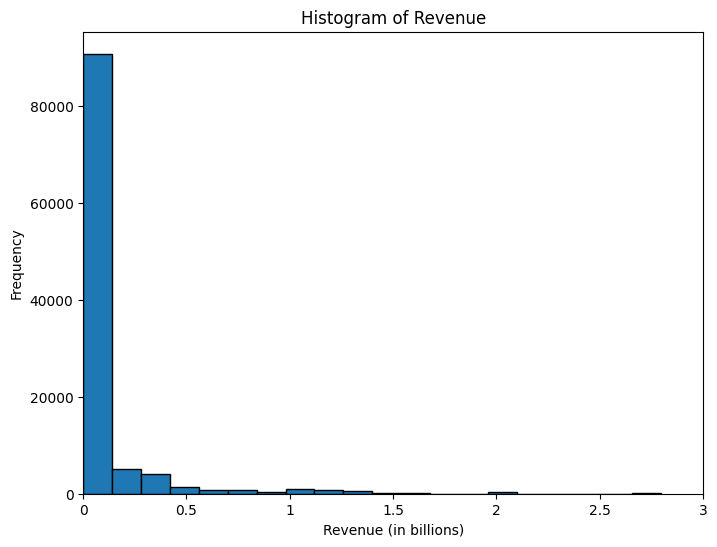

In [54]:
# Create a histogram of the 'Revenue' column
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(df['Revenue'], bins=20, edgecolor='black')

# Customize x-axis labels
ax.set_xlabel('Revenue (in billions)')
ax.set_ylabel('Frequency')
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1e9:g}'))
ax.set_xlim(0, 3e9)

plt.title('Histogram of Revenue')
plt.show()

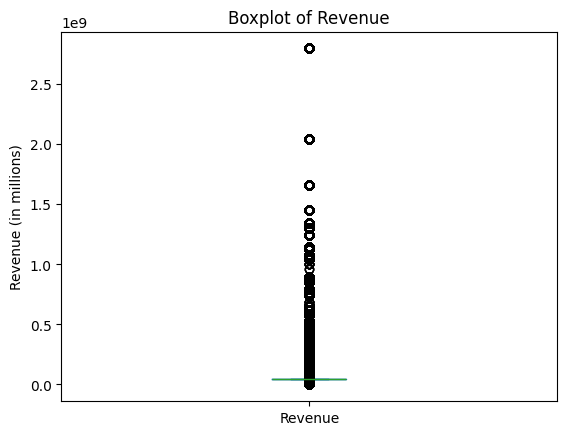

In [55]:
df['Revenue'].plot(kind='box')
plt.ylabel('Revenue (in millions)')
plt.title('Boxplot of Revenue')
plt.show()

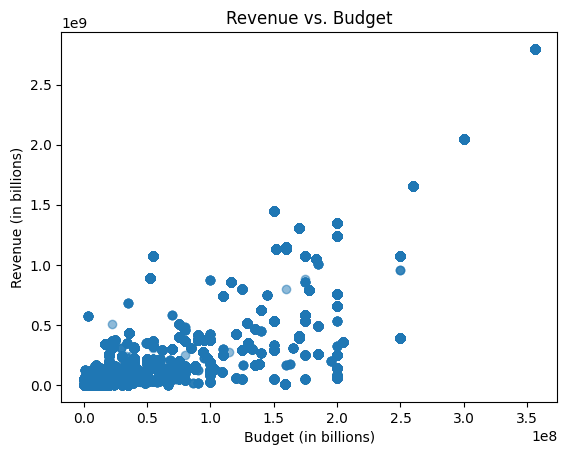

In [56]:
x = df['Budget']
y = df['Revenue']

plt.scatter(x, y, alpha=0.5)
plt.title('Revenue vs. Budget')
plt.xlabel('Budget (in billions)')
plt.ylabel('Revenue (in billions)')
plt.show()

In [57]:
#impute 
median_runtime = df['Runtime'].median()
df.loc[df['Runtime'] == 0, 'Runtime'] = median_runtime
df.loc[df['Runtime'] > 200, 'Runtime'] = median_runtime

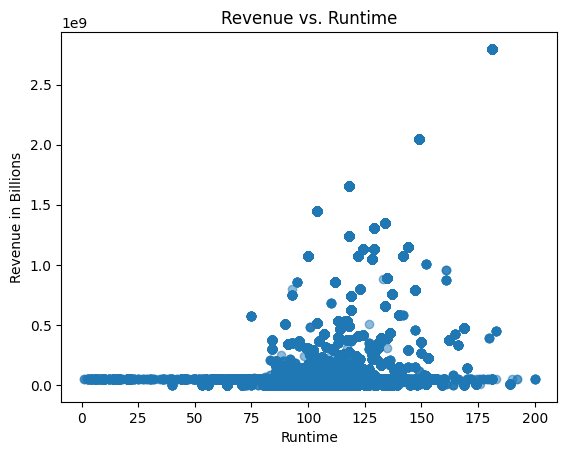

In [58]:
x = df['Runtime']
y = df['Revenue']

plt.scatter(x, y, alpha=0.5)
plt.title('Revenue vs. Runtime')
plt.xlabel('Runtime')
plt.ylabel('Revenue in Billions')
plt.show()

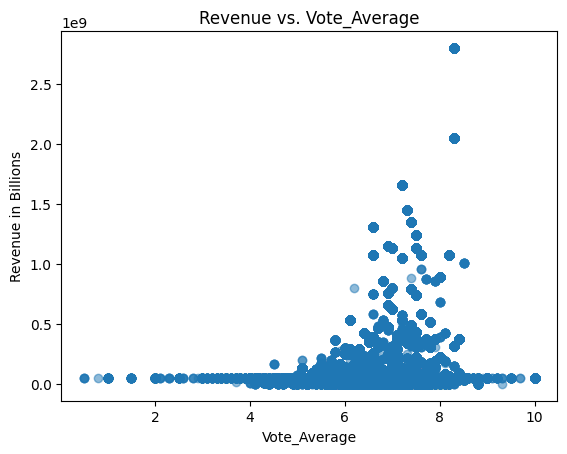

In [59]:
x = df['Vote_Average']
y = df['Revenue']

plt.scatter(x, y, alpha=0.5)
plt.title('Revenue vs. Vote_Average')
plt.xlabel('Vote_Average')
plt.ylabel('Revenue in Billions')
plt.show()

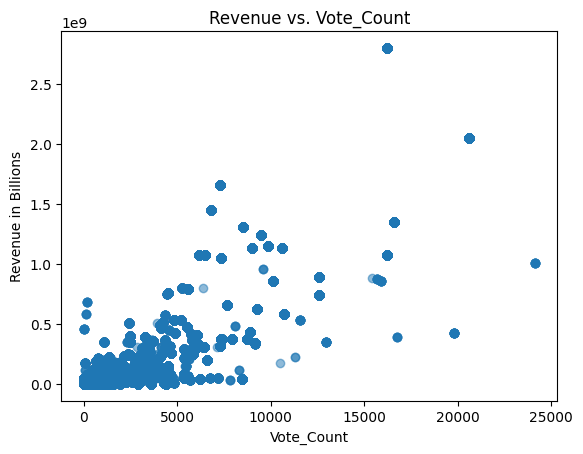

In [60]:
x = df['Vote_Count']
y = df['Revenue']

plt.scatter(x, y, alpha=0.5)
plt.title('Revenue vs. Vote_Count')
plt.xlabel('Vote_Count')
plt.ylabel('Revenue in Billions')
plt.show()

In [61]:
monthly_revenue = df.groupby('Month')['Revenue'].mean()

# Create a new DataFrame with the monthly labels and average revenues
monthlyrevenue = pd.DataFrame({
    'Month': monthly_revenue.index,
    'Average Revenue': monthly_revenue.values
})

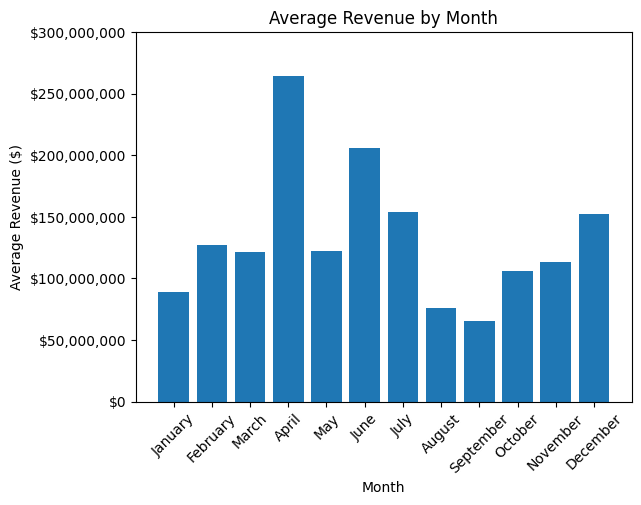

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define default blue color instead of the green color map
colors = 'C0'  # 'C0' is the default blue color in Matplotlib

# Create an ordered categorical data type for the 'Month' column
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
               'August', 'September', 'October', 'November', 'December']
cat_dtype = pd.api.types.CategoricalDtype(categories=month_order, ordered=True)
monthlyrevenue['Month'] = monthlyrevenue['Month'].astype(cat_dtype)

# Sort the dataframe by the 'Month' column
monthlyrevenue = monthlyrevenue.sort_values('Month')

# Create a bar plot with monthly revenue and color the bars by revenue
plt.bar(monthlyrevenue['Month'], monthlyrevenue['Average Revenue'], color=colors)

# Customize the plot
plt.xlabel('Month')
plt.ylabel('Average Revenue ($)')
plt.title('Average Revenue by Month')
plt.xticks(rotation=45)

# Set the y-axis tick labels
tick_labels = ['${:,.0f}'.format(x) for x in plt.yticks()[0]]
plt.yticks(plt.yticks()[0], tick_labels)

# Display the plot
plt.show()


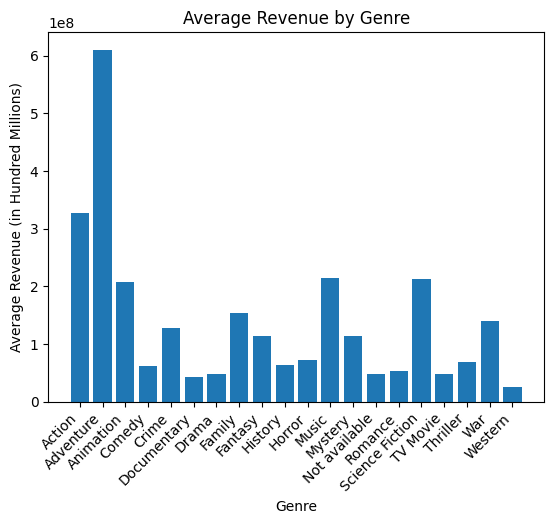

In [63]:
genre_revenue = df.groupby('Genre_1')['Revenue'].mean().reset_index()

# Create a bar plot with genre_1 and revenue
plt.bar(genre_revenue['Genre_1'], genre_revenue['Revenue'])
# Customize the plot
plt.xlabel('Genre')
plt.ylabel('Average Revenue (in Hundred Millions)')
plt.title('Average Revenue by Genre')
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.show()

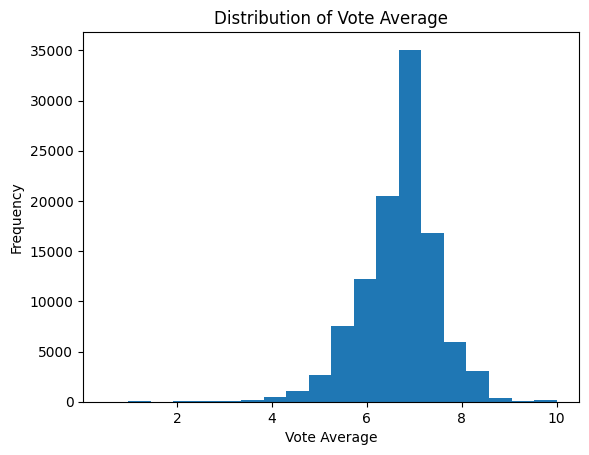

In [64]:
plt.hist(df['Vote_Average'], bins=20)
plt.title('Distribution of Vote Average')
plt.xlabel('Vote Average')
plt.ylabel('Frequency')
plt.show()

/Users/garrettmoran/Projects/personal/undergrad/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2911: RuntimeWarning: divide by zero encountered in dot
  c = dot(X, X_T.conj())
/Users/garrettmoran/Projects/personal/undergrad/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2911: RuntimeWarning: overflow encountered in dot
  c = dot(X, X_T.conj())
/Users/garrettmoran/Projects/personal/undergrad/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2911: RuntimeWarning: invalid value encountered in dot
  c = dot(X, X_T.conj())


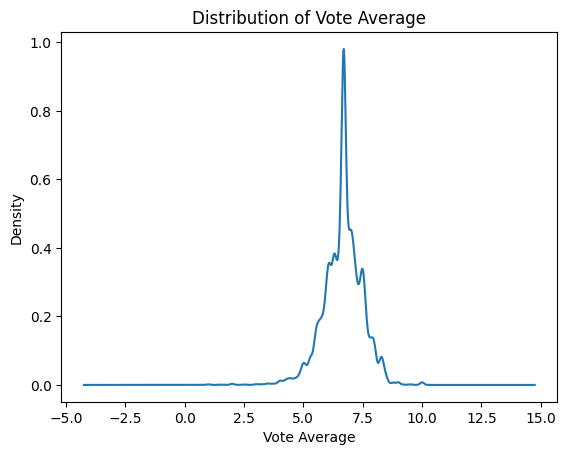

In [71]:
df['Vote_Average'].plot(kind='density')
plt.title('Distribution of Vote Average')
plt.xlabel('Vote Average')
plt.show()

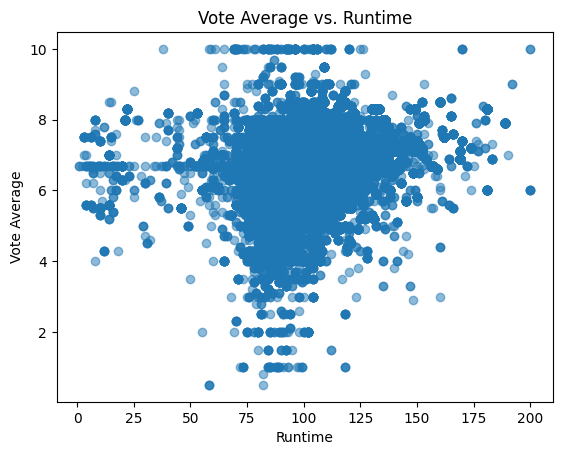

In [72]:
x = df['Runtime']
y = df['Vote_Average']

plt.scatter(x, y, alpha=0.5)
plt.title('Vote Average vs. Runtime')
plt.xlabel('Runtime')
plt.ylabel('Vote Average')
plt.show()

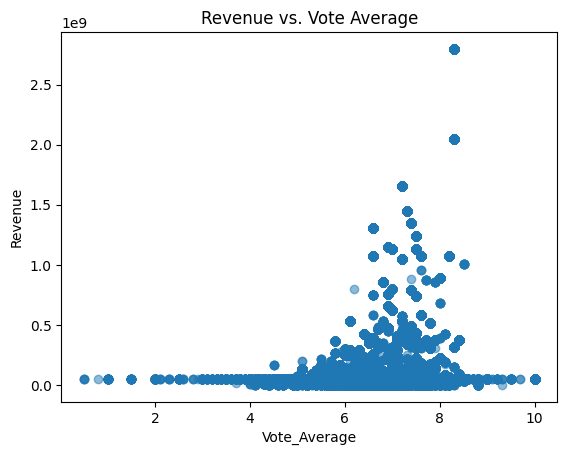

In [68]:
x = df['Vote_Average']
y = df['Revenue']

plt.scatter(x, y, alpha=0.5)
plt.title('Revenue vs. Vote Average')
plt.xlabel('Vote_Average')
plt.ylabel('Revenue')
plt.show()

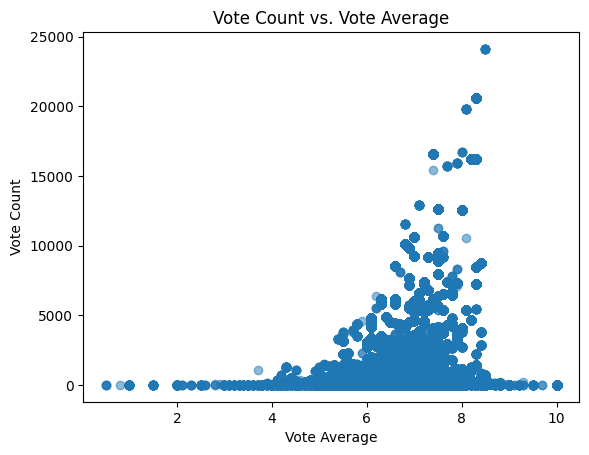

In [73]:
x = df['Vote_Average']
y = df['Vote_Count']

plt.scatter(x, y, alpha=0.5)
plt.title('Vote Count vs. Vote Average')
plt.xlabel('Vote Average')
plt.ylabel('Vote Count')
plt.show()

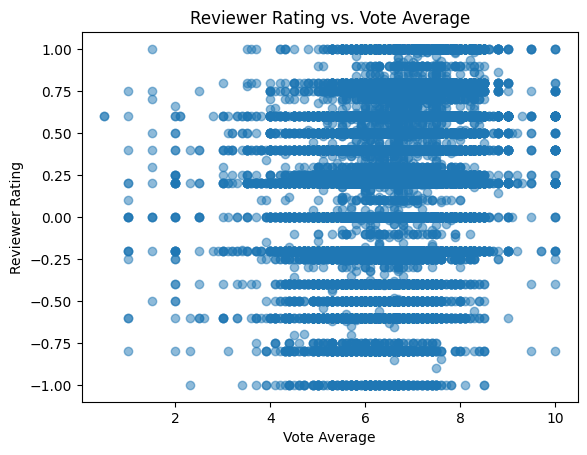

In [74]:
x = df['Vote_Average']
y = df['Reviewer_Rating']

plt.scatter(x, y, alpha=0.5)
plt.title('Reviewer Rating vs. Vote Average')
plt.xlabel('Vote Average')
plt.ylabel('Reviewer Rating')
plt.show()


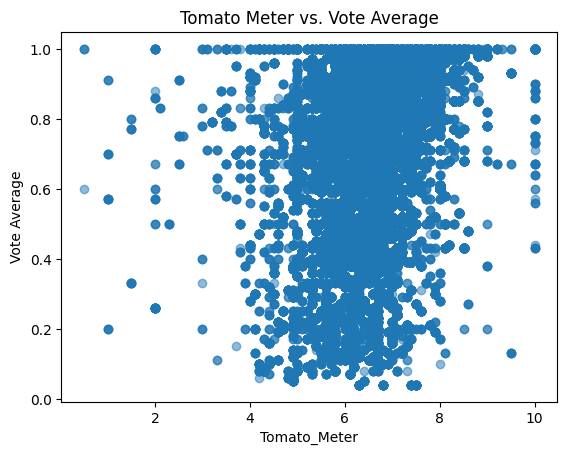

In [75]:
df_filtered = df[df['Tomato_Meter'] >= 0]
# create the scatter plot using the filtered dataframe
x = df_filtered['Vote_Average']
y = df_filtered['Tomato_Meter']

plt.scatter(x, y, alpha=0.5)
plt.title('Tomato Meter vs. Vote Average')
plt.xlabel('Tomato_Meter')
plt.ylabel('Vote Average')
plt.show()

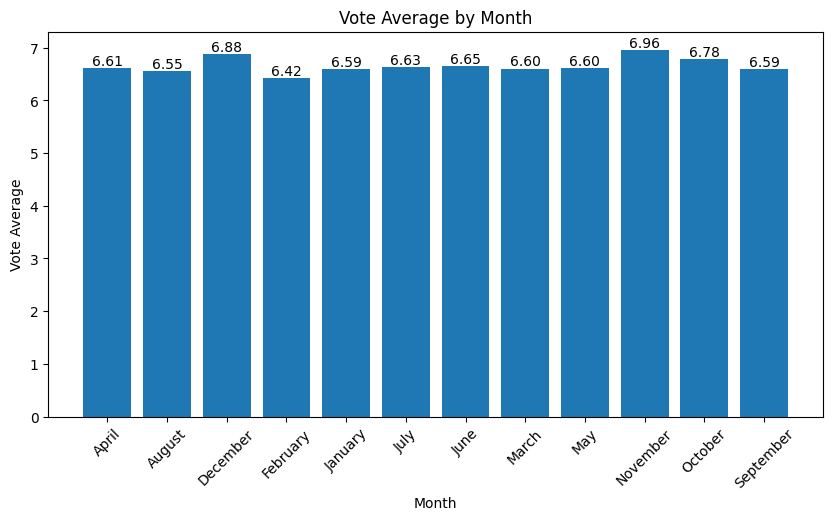

In [76]:
# Group the data by month and calculate the mean of the 'Vote Average' column
month_vote_avg = df.groupby('Month')['Vote_Average'].mean().reset_index()
plt.figure(figsize=(10, 5))
# Create a bar chart of vote average by month
plt.bar(month_vote_avg['Month'], month_vote_avg['Vote_Average'])
# Add data labels to the bars
for i, v in enumerate(month_vote_avg['Vote_Average']):
    plt.text(i, v, '{:.2f}'.format(v), ha='center', va='bottom')
# Customize the plot
plt.xlabel('Month')
plt.ylabel('Vote Average')
plt.title('Vote Average by Month')
plt.xticks(rotation=45)

# Display the plot
plt.show()

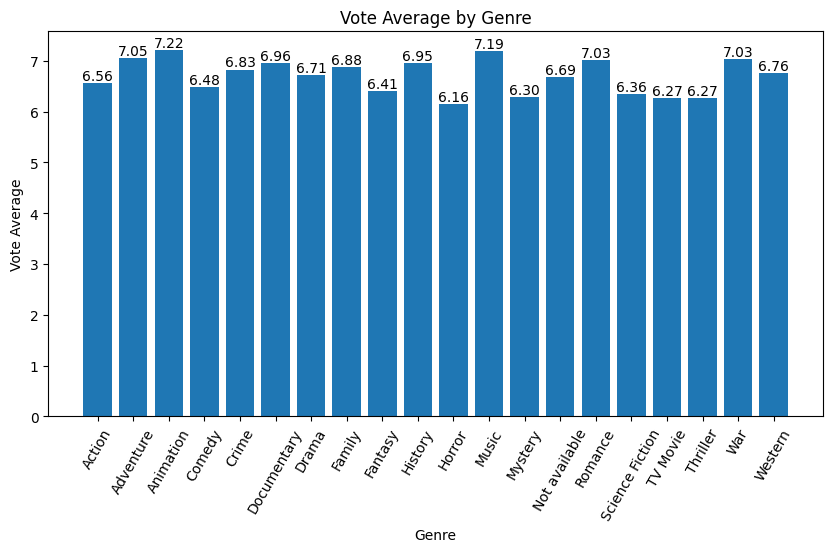

In [77]:
# Group the data by genre and calculate the mean of the 'Vote Average' column
genre_vote_avg = df.groupby('Genre_1')['Vote_Average'].mean().reset_index()
plt.figure(figsize=(10, 5))
# Create a bar chart of vote average by genre
plt.bar(genre_vote_avg['Genre_1'], genre_vote_avg['Vote_Average'])

# Add labels to the bars
for i, v in enumerate(genre_vote_avg['Vote_Average']):
    plt.text(i, v, '{:.2f}'.format(v), ha='center', va='bottom')

# Customize the plot
plt.xlabel('Genre')
plt.ylabel('Vote Average')
plt.title('Vote Average by Genre')
plt.xticks(rotation=60)

# Display the plot
plt.show()

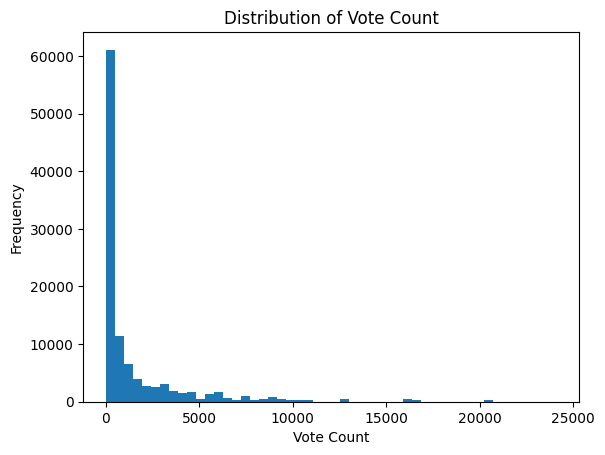

In [78]:
plt.hist(df['Vote_Count'], bins=50)
plt.title('Distribution of Vote Count')
plt.xlabel('Vote Count')
plt.ylabel('Frequency')
plt.show()

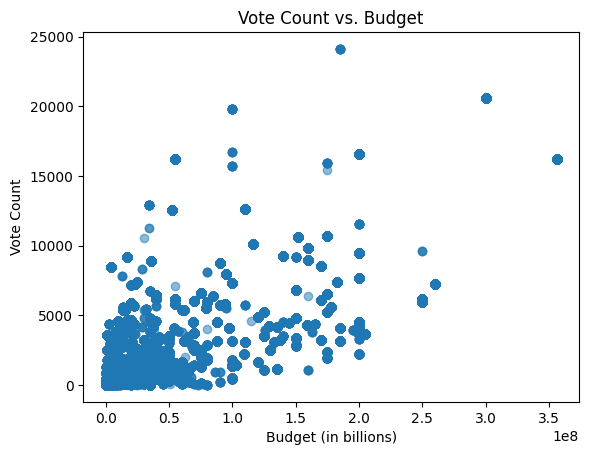

In [79]:
x = df['Budget']
y = df['Vote_Count']

plt.scatter(x, y, alpha=0.5)
plt.title('Vote Count vs. Budget')
plt.xlabel('Budget (in billions)')
plt.ylabel('Vote Count')
plt.show()

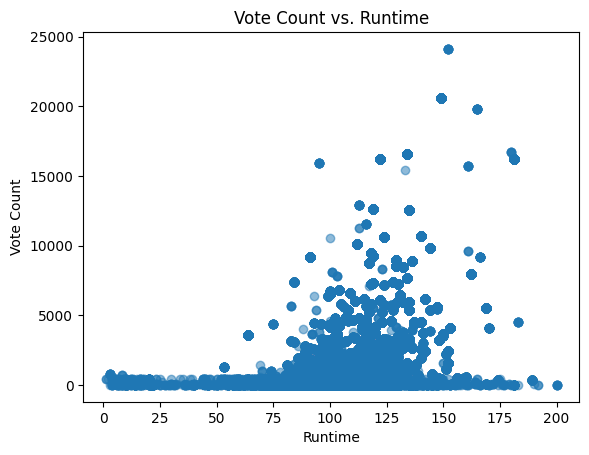

In [80]:
x = df['Runtime']
y = df['Vote_Count']

plt.scatter(x, y, alpha=0.5)
plt.title('Vote Count vs. Runtime')
plt.xlabel('Runtime')
plt.ylabel('Vote Count')
plt.show()

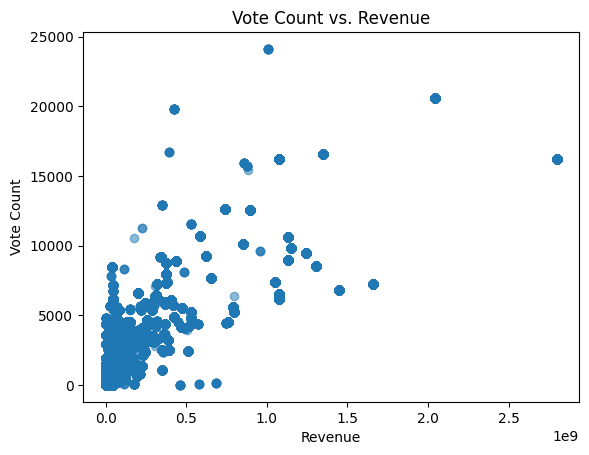

In [81]:
x = df['Revenue']
y = df['Vote_Count']

plt.scatter(x, y, alpha=0.5)
plt.title('Vote Count vs. Revenue')
plt.xlabel('Revenue')
plt.ylabel('Vote Count')
plt.show()

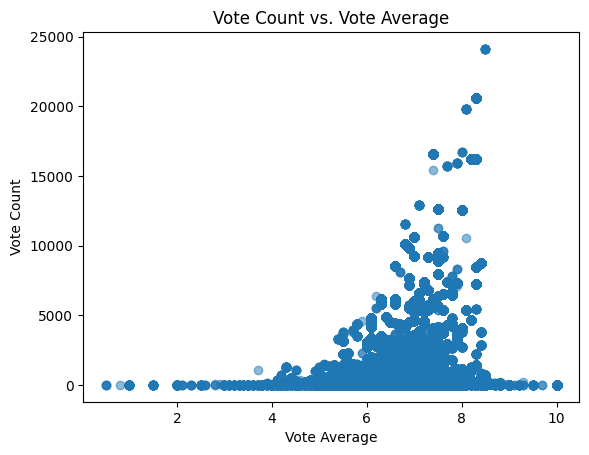

In [82]:
x = df['Vote_Average']
y = df['Vote_Count']

plt.scatter(x, y, alpha=0.5)
plt.title('Vote Count vs. Vote Average')
plt.xlabel('Vote Average')
plt.ylabel('Vote Count')
plt.show()

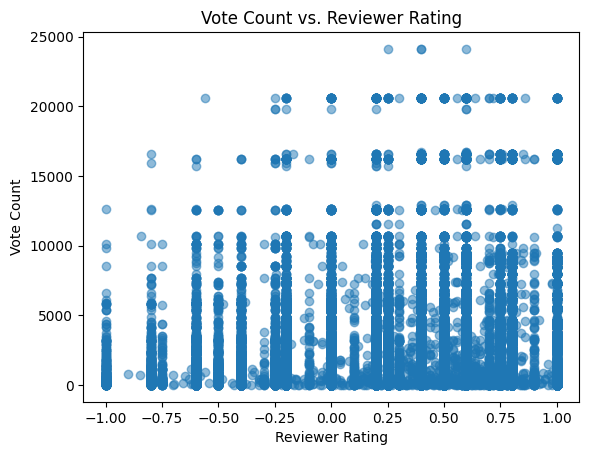

In [83]:
x = df['Reviewer_Rating']
y = df['Vote_Count']

plt.scatter(x, y, alpha=0.5)
plt.title('Vote Count vs. Reviewer Rating')
plt.xlabel('Reviewer Rating')
plt.ylabel('Vote Count')
plt.show()

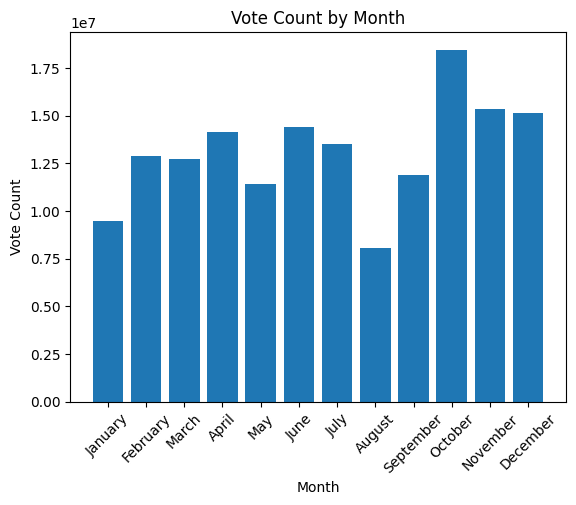

In [85]:
# Convert the 'Month' column to a categorical data type
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
               'August', 'September', 'October', 'November', 'December']
cat_dtype = pd.api.types.CategoricalDtype(categories=month_order, ordered=True)
df['Month'] = df['Month'].astype(cat_dtype)

# Group the data by month and calculate the sum of the 'Vote Count' column
monthly_vote_count = df.groupby('Month', observed=True)['Vote_Count'].sum().reset_index()

# Create a bar chart of vote count by month
plt.bar(monthly_vote_count['Month'], monthly_vote_count['Vote_Count'])

# Customize the plot
plt.xlabel('Month')
plt.ylabel('Vote Count')
plt.title('Vote Count by Month')
plt.xticks(rotation=45)

# Display the plot
plt.show()


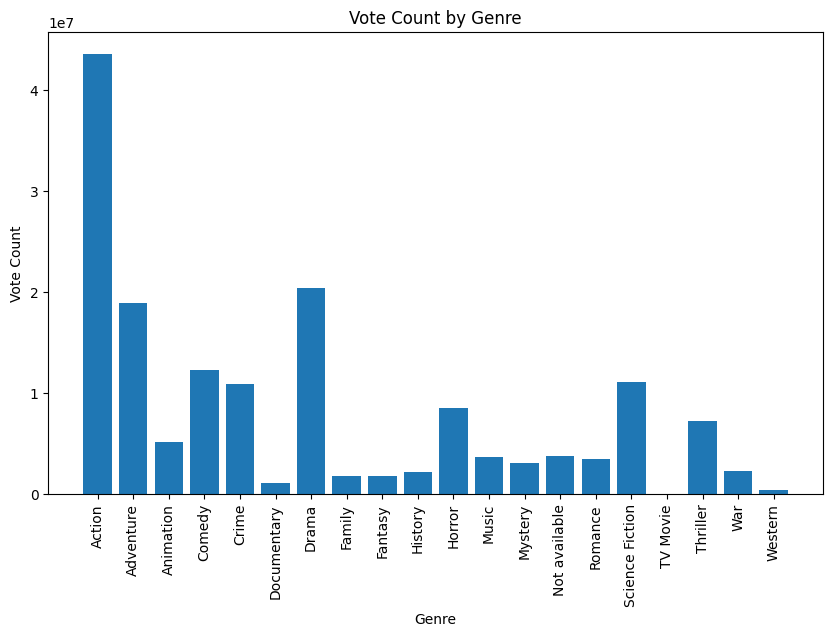

In [86]:
# Group the data by genre and calculate the sum of the 'Vote Count' column
genre_vote_count = df.groupby('Genre_1')['Vote_Count'].sum().reset_index()
plt.figure(figsize=(10, 6))
# Create a bar chart of vote count by genre
plt.bar(genre_vote_count['Genre_1'], genre_vote_count['Vote_Count'])

# Customize the plot
plt.xlabel('Genre')
plt.ylabel('Vote Count')
plt.title('Vote Count by Genre')
plt.xticks(rotation=90)

# Display the plot
plt.show()


object


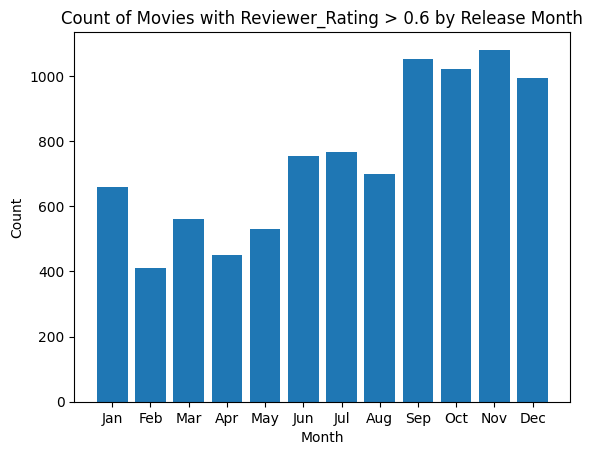

In [87]:
df_cleaned = df[df['Release_Date'] != 'Not available']
print(df_cleaned['Release_Date'].dtype)
df_cleaned['Release_Month'] = pd.to_datetime(df_cleaned['Release_Date']).dt.month

df_cleaned_rating = df_cleaned.dropna(subset=['Reviewer_Rating'])
df_cleaned_month_rating = df_cleaned_rating.dropna(subset=['Release_Month'])

# Group df_cleaned by month and get mean of Reviewer_Rating 
month_rating = df_cleaned_month_rating.groupby(['Release_Month'])['Reviewer_Rating'].mean()
import calendar
month_abbr = list(calendar.month_abbr)[1:] # Define a list of month abbreviations


df_filtered = df_cleaned[df_cleaned['Reviewer_Rating'] > 0.6]
count_by_month = df_filtered['Release_Month'].value_counts()
count_by_month = count_by_month.sort_index()

# Define month labels
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.bar(month_labels, count_by_month)
plt.title('Count of Movies with Reviewer_Rating > 0.6 by Release Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

# September is traditionally known as the start of the "fall movie season," where studios release 
# prestige films in the lead up to award season. This is because many of the high-profile film festivals 
# (Venice Film Festival and the Toronto International Film Festival) take place in September. As a result, 
# studios may choose to release their films in September in order to coincide with these festivals and 
# generate buzz and positive reviews for their films. Additionally, the period from September to December 
# leads up to the award season, during which studios release their most highly regarded and critically 
# acclaimed films in the hopes of receiving nominations and awards. This background information could 
# explain the higher count of reviewer_ratings above .6 from September to December. 

In [88]:
# select only the numeric columns
numeric_cols = df.select_dtypes(include=['int64', 'float64'])

# compute the correlation matrix
corr_matrix = numeric_cols.corr()

print(corr_matrix)

                      Budget   Runtime   Revenue  Popularity  Vote_Average  \
Budget              1.000000  0.341576  0.791391    0.197585      0.157223   
Runtime             0.341576  1.000000  0.359826    0.114639      0.293701   
Revenue             0.791391  0.359826  1.000000    0.082607      0.229579   
Popularity          0.197585  0.114639  0.082607    1.000000      0.074775   
Vote_Average        0.157223  0.293701  0.229579    0.074775      1.000000   
Vote_Count          0.654827  0.451191  0.825157    0.100609      0.339564   
Review_ID          -0.037746 -0.035006 -0.016210   -0.075019     -0.069894   
Critic_ID           0.018507  0.014663  0.017138    0.004182      0.007560   
Reviewer_Rating    -0.009650  0.079568  0.031469   -0.008397      0.280838   
Tomato_Meter        0.011233  0.102469  0.043551    0.006876      0.278321   
Publication         0.037309  0.031020  0.039050    0.013058      0.013514   
Review_Object_Year -0.062049 -0.097451 -0.117679    0.123636    

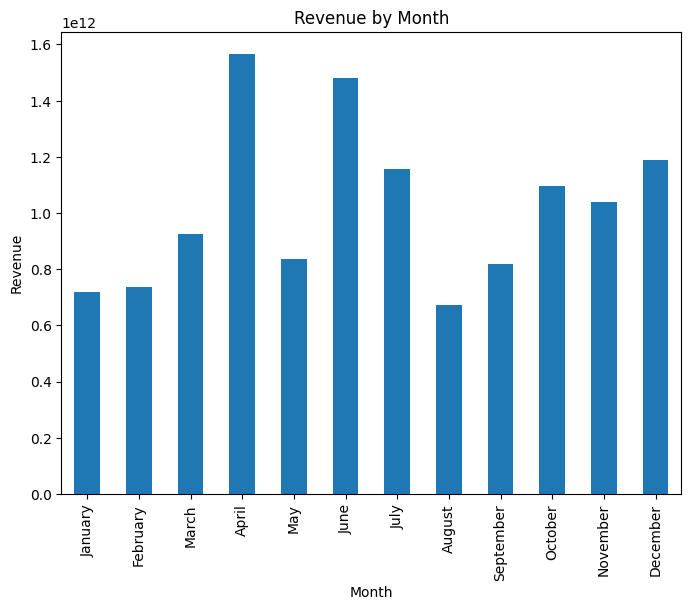

In [90]:
# Create a histogram of Revenue by Month
df.groupby('Month', observed=True)['Revenue'].sum().plot(kind='bar', title='Revenue by Month', figsize=(8, 6))
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.show()

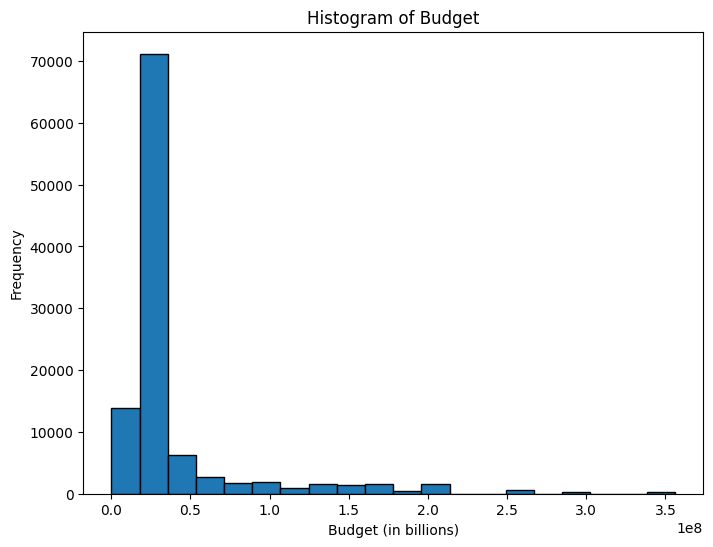

In [91]:
# Create a histogram of the 'Budget' column
plt.figure(figsize=(8,6))
plt.title('Histogram of Budget')
plt.xlabel('Budget (in billions)')
plt.ylabel('Frequency')
plt.hist(df['Budget'], bins=20, edgecolor='black')

plt.show()

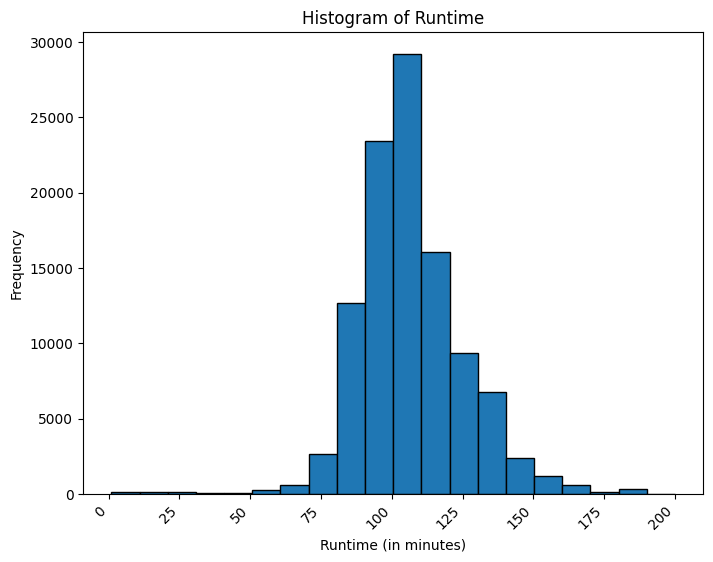

In [92]:
# Create a histogram of the 'Runtime' column
plt.figure(figsize=(8,6))
plt.title('Histogram of Runtime')
plt.xlabel('Runtime (in minutes)')
plt.ylabel('Frequency')
plt.hist(df['Runtime'], bins=20, edgecolor='black')

# Customize x-axis labels
plt.xticks(rotation=45, ha='right')
plt.ticklabel_format(style='plain', axis='x')

plt.show()

In [93]:
# END OF PART 2
# START OF PART 3

In [94]:
#Assignment requirements:
#1. Use either sentiment analyzer introduced in class to generate sentiment polarity scores for the content column in the dataframe.
#2. Impute NAs in the reviewer rating columns with the sentiment polarity scores 

In [96]:
#VADER ANALYSIS
import nltk
nltk.download('vader_lexicon')

analyzer = SentimentIntensityAnalyzer()
df.head() # The Content column contains the reviews that need to be analyzed.
#Content is what we will complete a sentiment analysis on. 

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/garrettmoran/nltk_data...


,Movie_Title,Num_Genres,Genre_1,Genre_2,Genre_3,Budget,Runtime,Original_Language,Revenue,Release_Date,...,Published_Date,Content,Publisher,Reviewer_Rating,Tomato_Meter,Publication,Review_Object_Year,Critic_Name,ROI,Month
Movie_ID,,,,,,,,,,,,,,,,,,,,,
6208.0,The Platform (El Hoyo),Not available,Not available,Not available,Not available,35000000.0,104.0,Not available,47800000.0,NaN,...,03/22/2020,Casts a stark light on all those socio-politic...,Flicks.co.nz,0.6,0.79,2339.0,2020.0,Aaron Yap,36.571429,NaN
6208.0,The Platform (El Hoyo),Not available,Not available,Not available,Not available,35000000.0,104.0,Not available,47800000.0,NaN,...,04/04/2020,"If you can stomach it ""The Platform"" is a funn...",Detroit News,0.6,0.79,122.0,2020.0,Adam Graham,36.571429,NaN
6208.0,The Platform (El Hoyo),Not available,Not available,Not available,Not available,35000000.0,104.0,Not available,47800000.0,NaN,...,03/23/2020,Somehow it works - probably because The Platfo...,Christianity Today,0.4,0.79,2588.0,2020.0,Alissa Wilkinson,36.571429,NaN
6208.0,The Platform (El Hoyo),Not available,Not available,Not available,Not available,35000000.0,104.0,Not available,47800000.0,NaN,...,03/20/2020,The Platform is about as subtle as a punch in ...,The Maine Edge,0.6,0.79,3284.0,2020.0,Allen Adams,36.571429,NaN
6208.0,The Platform (El Hoyo),Not available,Not available,Not available,Not available,35000000.0,104.0,Not available,47800000.0,NaN,...,09/12/2019,Gaztelu-Urrutia's allegory is clear. What he's...,Boxoffice Magazine,0.2,0.79,466.0,2020.0,Amy Nicholson,36.571429,NaN


In [97]:
# Check the contents of the first review for an initial review 
text1 = df.iloc[0].Content
text1

"Casts a stark light on all those socio-political triggers we're processing on a daily basis now more than ever: panic-driven consumption individualism-versus-collectivism the wealth divide."

In [98]:
# run the polarity scores on the 1st review to make sure the analyzer runs properly. 
analyzer.polarity_scores(text1) 
#{'neg': 0.0, 'neu': 0.873, 'pos': 0.127, 'compound': 0.4939}

{'neg': 0.0, 'neu': 0.873, 'pos': 0.127, 'compound': 0.4939}

In [99]:
# The following code saves the absolute compound polarity scores in the column Polarity_Score and the sentiment label (positive or negative) in a column called Sentiment 
compounds=[]
values=[]
for index, row in df.iterrows():
    text = row.Content
    scores = analyzer.polarity_scores(text)
    compounds.append(scores['compound'])
    if scores['compound']>0:
        values.append('POSITIVE')
    else:
        values.append('NEGATIVE')

df['Polarity_Score']=compounds
df['Polarity_Score']=df['Polarity_Score'].round(3)
df['Sentiment']=values

In [100]:
df.head(100)

,Movie_Title,Num_Genres,Genre_1,Genre_2,Genre_3,Budget,Runtime,Original_Language,Revenue,Release_Date,...,Publisher,Reviewer_Rating,Tomato_Meter,Publication,Review_Object_Year,Critic_Name,ROI,Month,Polarity_Score,Sentiment
Movie_ID,,,,,,,,,,,,,,,,,,,,,
6208.0,The Platform (El Hoyo),Not available,Not available,Not available,Not available,35000000.0,104.0,Not available,47800000.0,NaN,...,Flicks.co.nz,0.6,0.79,2339.0,2020.0,Aaron Yap,36.571429,NaN,0.494,POSITIVE
6208.0,The Platform (El Hoyo),Not available,Not available,Not available,Not available,35000000.0,104.0,Not available,47800000.0,NaN,...,Detroit News,0.6,0.79,122.0,2020.0,Adam Graham,36.571429,NaN,0.052,POSITIVE
6208.0,The Platform (El Hoyo),Not available,Not available,Not available,Not available,35000000.0,104.0,Not available,47800000.0,NaN,...,Christianity Today,0.4,0.79,2588.0,2020.0,Alissa Wilkinson,36.571429,NaN,0.026,POSITIVE
6208.0,The Platform (El Hoyo),Not available,Not available,Not available,Not available,35000000.0,104.0,Not available,47800000.0,NaN,...,The Maine Edge,0.6,0.79,3284.0,2020.0,Allen Adams,36.571429,NaN,0.749,POSITIVE
6208.0,The Platform (El Hoyo),Not available,Not available,Not available,Not available,35000000.0,104.0,Not available,47800000.0,NaN,...,Boxoffice Magazine,0.2,0.79,466.0,2020.0,Amy Nicholson,36.571429,NaN,0.660,POSITIVE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6017.0,The Lighthouse,4.0,Drama,Fantasy,Thriller,4000000.0,109.0,English,17964238.0,2019-10-18,...,Collider,0.6,0.90,1982.0,2019.0,Gregory Ellwood,349.105950,October,0.000,NEGATIVE
6017.0,The Lighthouse,4.0,Drama,Fantasy,Thriller,4000000.0,109.0,English,17964238.0,2019-10-18,...,Dread Central,0.6,0.90,2723.0,2019.0,Heather Wixson,349.105950,October,0.382,POSITIVE
6017.0,The Lighthouse,4.0,Drama,Fantasy,Thriller,4000000.0,109.0,English,17964238.0,2019-10-18,...,Guardian,NaN,0.71,466.0,2018.0,Guy Lodge,349.105950,October,-0.308,NEGATIVE


In [102]:
#FLAIR
import flair
from flair.models import TextClassifier
from flair.data import Sentence
import pandas as pd
df1= pd.read_csv('merged_file.csv').head(100)

classifier = TextClassifier.load('en-sentiment')
sentence = Sentence('The food was mid.')
classifier.predict(sentence)
print(sentence)

/Users/garrettmoran/Projects/personal/undergrad/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2025-06-07 21:23:35,605 https://nlp.informatik.hu-berlin.de/resources/models/sentiment-curated-distilbert/sentiment-en-mix-distillbert_4.pt not found in cache, downloading to /var/folders/b_/rjwb6fz16_96hy68dswwvyw40000gn/T/tmp9pi97hwd


100%|██████████| 253M/253M [55:03<00:00, 80.4kB/s]    

2025-06-07 22:18:40,047 copying /var/folders/b_/rjwb6fz16_96hy68dswwvyw40000gn/T/tmp9pi97hwd to cache at /Users/garrettmoran/.flair/models/sentiment-en-mix-distillbert_4.pt


2025-06-07 22:18:40,158 removing temp file /var/folders/b_/rjwb6fz16_96hy68dswwvyw40000gn/T/tmp9pi97hwd
Sentence[5]: "The food was mid." → NEGATIVE (0.9918)


In [104]:
#flair values
values2 = []
scores = []

for index, row in df1.iterrows():
    text = Sentence(row.Content)
    classifier.predict(text)
    values2.append(text.labels[0].value)   # 'POSITIVE' or 'NEGATIVE'
    scores.append(text.labels[0].score)    # confidence (0.0 to 1.0)

df1['Sentiment'] = values2
df1['Polarity'] = scores #Scores are absolute instead of [-1,1] from Vader
df1

,Movie_Title,genres,Budget,Runtime,Original_Language,Revenue,Release_Date,Popularity,Vote_Average,Vote_Count,...,Reviewer_Rating,Tomato_Meter,Publication,Review_Object_Year,Critic_Name,Movie_ID,ROI,Month,Sentiment,Polarity
0,#Alive,Action|Horror|Thriller|Science Fiction,35000000.0,86.0,NaN,47800000.0,2020-07-07,75.455,3.6,11.0,...,NaN,0.88,1879.0,2020.0,Felix Vasquez Jr.,1.0,36.571429,July,POSITIVE,0.997647
1,#Alive,Action|Horror|Thriller|Science Fiction,35000000.0,86.0,NaN,47800000.0,2020-07-07,75.455,3.6,11.0,...,0.6,0.88,720.0,2020.0,John Lui,1.0,36.571429,July,POSITIVE,0.983515
2,#Alive,Action|Horror|Thriller|Science Fiction,35000000.0,86.0,NaN,47800000.0,2020-07-07,75.455,3.6,11.0,...,0.2,0.88,3784.0,2020.0,Matt Donato,1.0,36.571429,July,POSITIVE,0.908481
3,#Alive,Action|Horror|Thriller|Science Fiction,35000000.0,86.0,NaN,47800000.0,2020-07-07,75.455,3.6,11.0,...,NaN,0.88,2715.0,2020.0,Scott Weinberg,1.0,36.571429,July,POSITIVE,0.997565
4,#AnneFrank. Parallel Stories (Vite parallele),NaN,35000000.0,104.0,Not available,47800000.0,NaN,15.447,6.7,403.0,...,0.6,1.00,437.0,2019.0,Edward Porter,2.0,36.571429,NaN,POSITIVE,0.999808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,12 Hour Shift,Thriller|Horror|Comedy|Crime,35000000.0,86.0,NaN,47800000.0,2020-10-02,85.685,5.2,84.0,...,0.2,0.76,28.0,2020.0,Josh Kupecki,23.0,36.571429,October,POSITIVE,0.998851
96,12 Hour Shift,Thriller|Horror|Comedy|Crime,35000000.0,86.0,NaN,47800000.0,2020-10-02,85.685,5.2,84.0,...,0.6,0.76,3062.0,2020.0,Kat Hughes,23.0,36.571429,October,POSITIVE,0.998282
97,12 Hour Shift,Thriller|Horror|Comedy|Crime,35000000.0,86.0,NaN,47800000.0,2020-10-02,85.685,5.2,84.0,...,0.4,0.76,833.0,2020.0,Katie Rife,23.0,36.571429,October,POSITIVE,0.991974
98,12 Hour Shift,Thriller|Horror|Comedy|Crime,35000000.0,86.0,NaN,47800000.0,2020-10-02,85.685,5.2,84.0,...,NaN,0.76,1676.0,2020.0,Kristy Puchko,23.0,36.571429,October,POSITIVE,0.996902


In [106]:
#The Vader values are a little bit more accurate for the Content column versus the Flair style. 
#Example: 
#Row 4: The Platform is about as subtle as a punch in the face but that's by design. It's social commentary via blunt instrument using genre trappings and pitch-black satire as a club bashing at its targets with barely restrained glee.
#Row 98: Crow and his two fine Welsh-burred leads commit fully to the anguished nerve-fraying cause but their efforts can't conceal a certain thinness to the dramatic material...
#Row 100: Many audiences are going to be utterly shocked at the lengths the two leading actors Pattinson Dafoe are pushed. They have a loathsome dynamic. However those who can get on 
#  Eggers' level will be hypnotized by this eccentric experiment.

#The flair analysis designates these ratings as negative, but after reading the rating itself, I would consider these as more positive than negative. 
#Thus, we will use Vader as the sentiment analysis reasoning. 

In [107]:
#impute the NAs of Reviewer_Rating with the polarity score
df['Reviewer_Rating'] = df['Reviewer_Rating'].fillna(df.pop('Polarity_Score'))
#this code replaces the Reviewer_Rating with Polarity Score and deletes Polarity score column. Retain the sentiment column for now. 

In [108]:
#Written to CSV
df.to_csv('merged_file.csv', index=False)

In [109]:
# END OF PART 3
# START OF PART 4

In [ ]:
## 1. Use regression algorithms to predict movie success (the factors you selected in Phase 2) 
## based on  relevant variables (IVs). Make sure  you include the reviewer rating variable with NAs being imputed either as an IV or DV in your model analysis (20 pts)

In [139]:
# make a copy of the original DataFrame
df = pd.read_csv('merged_file.csv', index_col=0)
df_copy = df.copy()

# create dummy variables for Month and Genre columns
dummy_month = pd.get_dummies(df_copy['Month'],drop_first=True,dtype='int')
dummy_genre = pd.get_dummies(df_copy['Genre_1'],drop_first=True,dtype='int')

# concatenate the dummy variables with the original DataFrame
df_copy = pd.concat([df_copy, dummy_month, dummy_genre], axis=1)
df_copy

,Num_Genres,Genre_1,Genre_2,Genre_3,Budget,Runtime,Original_Language,Revenue,Release_Date,Popularity,...,Horror,Music,Mystery,Not available,Romance,Science Fiction,TV Movie,Thriller,War,Western
Movie_Title,,,,,,,,,,,,,,,,,,,,,
The Platform (El Hoyo),Not available,Not available,Not available,Not available,35000000.0,104.0,Not available,47800000.0,NaN,15.447,...,0,0,0,1,0,0,0,0,0,0
The Platform (El Hoyo),Not available,Not available,Not available,Not available,35000000.0,104.0,Not available,47800000.0,NaN,15.447,...,0,0,0,1,0,0,0,0,0,0
The Platform (El Hoyo),Not available,Not available,Not available,Not available,35000000.0,104.0,Not available,47800000.0,NaN,15.447,...,0,0,0,1,0,0,0,0,0,0
The Platform (El Hoyo),Not available,Not available,Not available,Not available,35000000.0,104.0,Not available,47800000.0,NaN,15.447,...,0,0,0,1,0,0,0,0,0,0
The Platform (El Hoyo),Not available,Not available,Not available,Not available,35000000.0,104.0,Not available,47800000.0,NaN,15.447,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Anerca, Breath Of Life (Anerca, ElÌ?mÌ?n Hengitys)",Not available,Not available,Not available,Not available,35000000.0,104.0,Not available,47800000.0,NaN,15.447,...,0,0,0,1,0,0,0,0,0,0
Dance with Me (Dansu wizu mÌ¨),Not available,Not available,Not available,Not available,35000000.0,104.0,Not available,47800000.0,NaN,15.447,...,0,0,0,1,0,0,0,0,0,0
What Might Have Been (Was gewesen wÌ?re),Not available,Not available,Not available,Not available,35000000.0,104.0,Not available,47800000.0,NaN,15.447,...,0,0,0,1,0,0,0,0,0,0


In [140]:
# remove the original Month and Genre columns
df_copy = df_copy.drop(['Month', 'Genre_1', 'Genre_2', 'Genre_3'], axis=1)

# drop rows with missing or infinite values
df_copy = df_copy.replace([np.inf, -np.inf], np.nan).dropna()

# filter the DataFrame to include only numeric columns
df_copy = df_copy.select_dtypes(include='number')
df_copy

,Budget,Runtime,Revenue,Popularity,Vote_Average,Vote_Count,Review_ID,Critic_ID,Reviewer_Rating,Tomato_Meter,...,Horror,Music,Mystery,Not available,Romance,Science Fiction,TV Movie,Thriller,War,Western
Movie_Title,,,,,,,,,,,,,,,,,,,,,
The Lighthouse,4000000.0,109.0,17964238.0,27.974,7.6,2262.0,7.0,6.0,0.600,0.90,...,0,0,0,0,0,0,0,0,0,0
The Lighthouse,4000000.0,109.0,17964238.0,27.974,7.6,2262.0,107.0,1.0,0.600,0.90,...,0,0,0,0,0,0,0,0,0,0
The Lighthouse,4000000.0,109.0,17964238.0,27.974,7.6,2262.0,116.0,7.0,0.400,0.90,...,0,0,0,0,0,0,0,0,0,0
The Lighthouse,4000000.0,109.0,17964238.0,27.974,7.6,2262.0,73.0,17.0,-0.318,0.90,...,0,0,0,0,0,0,0,0,0,0
The Lighthouse,4000000.0,109.0,17964238.0,27.974,7.6,2262.0,185.0,13.0,0.800,0.90,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
The Thing About Harry,35000000.0,85.0,47800000.0,14.678,7.9,88.0,16.0,1431.0,0.670,1.00,...,0,0,0,0,1,0,0,0,0,0
Brother of the Year,35000000.0,125.0,47800000.0,1.452,8.1,15.0,28.0,1437.0,0.400,-1.00,...,0,0,0,0,1,0,0,0,0,0
Padrenostro,35000000.0,120.0,47800000.0,4.293,6.8,49.0,9.0,1436.0,0.200,0.67,...,0,0,0,0,0,0,0,0,0,0


In [141]:
# create independent variable matrix X and dependent variable vector y
X = df_copy.drop(columns=['Revenue'])
y = df_copy['Revenue']
# add constant term to X matrix
X = sm.add_constant(X)
# fit OLS model
model1 = sm.OLS(y, X).fit()
# print summary of model
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                Revenue   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                 1.058e+04
Date:                Sun, 08 Jun 2025   Prob (F-statistic):               0.00
Time:                        07:58:42   Log-Likelihood:            -1.9491e+06
No. Observations:               97423   AIC:                         3.898e+06
Df Residuals:                   97380   BIC:                         3.899e+06
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -2.841e+10    1.1

/Users/garrettmoran/Projects/personal/undergrad/.venv/lib/python3.12/site-packages/statsmodels/tools/tools.py:274: RuntimeWarning: divide by zero encountered in dot
  res = np.dot(np.transpose(vt), np.multiply(s[:, np.newaxis],
/Users/garrettmoran/Projects/personal/undergrad/.venv/lib/python3.12/site-packages/statsmodels/tools/tools.py:274: RuntimeWarning: overflow encountered in dot
  res = np.dot(np.transpose(vt), np.multiply(s[:, np.newaxis],
/Users/garrettmoran/Projects/personal/undergrad/.venv/lib/python3.12/site-packages/statsmodels/tools/tools.py:274: RuntimeWarning: invalid value encountered in dot
  res = np.dot(np.transpose(vt), np.multiply(s[:, np.newaxis],
/Users/garrettmoran/Projects/personal/undergrad/.venv/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:334: RuntimeWarning: divide by zero encountered in dot
  self.normalized_cov_params = np.dot(
/Users/garrettmoran/Projects/personal/undergrad/.venv/lib/python3.12/site-packages/statsmodels/regression/l

In [142]:
# Check vifs
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif)

/Users/garrettmoran/Projects/personal/undergrad/.venv/lib/python3.12/site-packages/statsmodels/tools/tools.py:274: RuntimeWarning: divide by zero encountered in dot
  res = np.dot(np.transpose(vt), np.multiply(s[:, np.newaxis],
/Users/garrettmoran/Projects/personal/undergrad/.venv/lib/python3.12/site-packages/statsmodels/tools/tools.py:274: RuntimeWarning: overflow encountered in dot
  res = np.dot(np.transpose(vt), np.multiply(s[:, np.newaxis],
/Users/garrettmoran/Projects/personal/undergrad/.venv/lib/python3.12/site-packages/statsmodels/tools/tools.py:274: RuntimeWarning: invalid value encountered in dot
  res = np.dot(np.transpose(vt), np.multiply(s[:, np.newaxis],
/Users/garrettmoran/Projects/personal/undergrad/.venv/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:334: RuntimeWarning: divide by zero encountered in dot
  self.normalized_cov_params = np.dot(
/Users/garrettmoran/Projects/personal/undergrad/.venv/lib/python3.12/site-packages/statsmodels/regression/l

    VIF Factor            features
0     0.000000               const
1     2.385145              Budget
2     1.598153             Runtime
3     1.124440          Popularity
4     1.566658        Vote_Average
5     2.579522          Vote_Count
6     1.170885           Review_ID
7     1.004345           Critic_ID
8     1.134054     Reviewer_Rating
9     1.210628        Tomato_Meter
10    1.013694         Publication
11    1.292645  Review_Object_Year
12    1.002228                 ROI
13    2.339906              August
14    2.252802            December
15    1.940711            February
16    2.216432             January
17    2.169816                July
18    2.079143                June
19    2.147385               March
20    2.039091                 May
21    2.418157            November
22    2.525927             October
23    2.805334           September
24    1.374971           Adventure
25    1.372921           Animation
26    2.139405              Comedy
27    1.374625      

### OLS results for **Revenue** (no stepwise selection, no standardization)  
**Adj. R² = 0.820** **N = 97 423** F-statistic ≈ 1.1 × 10⁴ p(F) < 0.001  

The model explains 82 % of the variance in box-office revenue. The condition number is large (≈ 1.9 × 10¹¹), but all VIFs are below 3, indicating no serious multicollinearity. Numerical scaling or ridge regularisation would still improve stability.

---

#### Continuous predictors  

| Variable          | Coefficient (USD)         | p-value | Comment |
|-------------------|--------------------------:|--------:|---------|
| Budget (per \$1 M)       | **+2.59 M** | <0.001 | Strong, direct driver of revenue |
| Vote_Count (per 1 000)   | **+59 k**  | <0.001 | Audience reach matters |
| Vote_Average              | **–17.9 M** | <0.001 | Higher‐scoring films tend to be limited-release or niche |
| Tomato_Meter              | **–4.81 M** | <0.001 | Critical acclaim alone does not boost revenue |
| Popularity                | **–87.8 k** | <0.001 | TMDB “buzz” is negatively correlated with revenue in this set |
| Review_Object_Year        | **+14.1 M** | <0.001 | Later reviews (younger titles) earn more |
| ROI                       | **+0.61**  | <0.001 | Positive but small monetary effect |
| Runtime                   | –15.7 k    | 0.52   | Not significant |
| Reviewer_Rating           | +1.28 M    | 0.17   | Not significant |
| Critic_ID                 | –1.51 k    | 0.10   | Marginal |

---

#### Seasonality (April is the reference month)  

| Month       | Δ Revenue (Millions) | Significant |
|-------------|---------------------:|:-----------:|
| August      | –42.7 | Yes |
| December    | –47.7 | Yes |
| February    | –79.3 | Yes |
| January     | –48.6 | Yes |
| July        | –44.6 | Yes |
| June        | –14.3 | Yes |
| March       | –63.5 | Yes |
| May         | –62.2 | Yes |
| November    | –58.8 | Yes |
| October     | –61.6 | Yes |
| September   | –41.4 | Yes |

Releases outside April under-perform, with February and March showing the steepest declines.

---

#### Genre effects (Drama/unclassified is baseline)  

| Genre            | Δ Revenue (Millions) | Significant |
|------------------|---------------------:|:-----------:|
| Adventure        | +112.7 | Yes |
| Animation        | +72.6  | Yes |
| Comedy           | +31.1  | Yes |
| Documentary      | +65.3  | Yes |
| Fantasy          | +13.2  | Yes |
| History          | +10.5  | Yes |
| Horror           | +28.8  | Yes |
| Music            | +67.6  | Yes |
| Not available    | +44.1  | Yes |
| Romance          | +78.8  | Yes |
| Thriller         | +29.6  | Yes |
| TV Movie         | +54.2  | Yes |
| Action           | +31.1  | Yes |
| Crime            | –21.1  | Yes |
| Mystery          | –16.7  | Yes |
| Science Fiction  | –128.9 | Yes |
| War              | –53.3  | Yes |
| Western          | –23.5  | Yes |
| Family           | –8.0   | 0.035 |

Family, Crime, Sci-Fi, War, and Western genres depress revenue, while Adventure, Animation, Romance, and Documentary show the highest positive impact.

---

### Interpretation

* **Budget** and **audience engagement** (Vote_Count) remain the strongest positive predictors.  
* High **critic/audience scores** (Vote_Average, Tomato_Meter) correlate negatively with revenue, suggesting a divide between critical reception and commercial performance.  
* **April releases** outperform every other month; films launched in late winter (February–March) perform poorest.  
* Genre choice is pivotal: big-budget, crowd-pleasing genres (Adventure, Animation, Romance) add tens of millions, whereas niche or serious genres (Science Fiction in this data, War, Western) reduce expected revenue.  

### Next steps

1. Standardise predictors or apply Ridge/Lasso to curb numerical warnings.  
2. Test interaction terms (e.g., Budget × Genre) to capture genre-specific ROI.  
3. Explore non-linear models or tree-based methods for potential gains beyond the 82 % variance explained here.

In [143]:
# New Model 1 - Standardized - Revenue as DV
df_copy

,Budget,Runtime,Revenue,Popularity,Vote_Average,Vote_Count,Review_ID,Critic_ID,Reviewer_Rating,Tomato_Meter,...,Horror,Music,Mystery,Not available,Romance,Science Fiction,TV Movie,Thriller,War,Western
Movie_Title,,,,,,,,,,,,,,,,,,,,,
The Lighthouse,4000000.0,109.0,17964238.0,27.974,7.6,2262.0,7.0,6.0,0.600,0.90,...,0,0,0,0,0,0,0,0,0,0
The Lighthouse,4000000.0,109.0,17964238.0,27.974,7.6,2262.0,107.0,1.0,0.600,0.90,...,0,0,0,0,0,0,0,0,0,0
The Lighthouse,4000000.0,109.0,17964238.0,27.974,7.6,2262.0,116.0,7.0,0.400,0.90,...,0,0,0,0,0,0,0,0,0,0
The Lighthouse,4000000.0,109.0,17964238.0,27.974,7.6,2262.0,73.0,17.0,-0.318,0.90,...,0,0,0,0,0,0,0,0,0,0
The Lighthouse,4000000.0,109.0,17964238.0,27.974,7.6,2262.0,185.0,13.0,0.800,0.90,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
The Thing About Harry,35000000.0,85.0,47800000.0,14.678,7.9,88.0,16.0,1431.0,0.670,1.00,...,0,0,0,0,1,0,0,0,0,0
Brother of the Year,35000000.0,125.0,47800000.0,1.452,8.1,15.0,28.0,1437.0,0.400,-1.00,...,0,0,0,0,1,0,0,0,0,0
Padrenostro,35000000.0,120.0,47800000.0,4.293,6.8,49.0,9.0,1436.0,0.200,0.67,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Define predictor and dependent variables
X = df_copy[['Popularity', 'Vote_Count',
        'Tomato_Meter', 'Reviewer_Rating', 
        'April', 'August', 'December', 'February', 'January', 'June',
        'March', 'May', 'November', 'October', 'September', 'Action',
        'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary',
        'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Mystery',
        'Romance', 'Science Fiction', 'Thriller', 'War', 'Western']] 

y = df['Revenue']

# Remove TV movie because it's not statistically significant
# Remove Drama because its correlation with Revenue is only -.15 AND it has a problematic VIF of 25.27
# Remove July because its correlation is only .03 and is not statistically significant
# Remove Budget because it has multicollinearity with Vote_Count. Vote_Count has a higher correlation at .82, so remove Budget 
# Remove Runtime and Vote_Average due to multicollinearity 

# Standardize predictor variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Add constant term to X matrix
X_scaled = sm.add_constant(X_scaled)

# Fit OLS model
model = sm.OLS(y, X_scaled).fit()

# Print summary of model results
print(model.summary())

In [ ]:
# Check vifs
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif)

In [ ]:
print(X.shape)
print(y.shape)
y.reset_index(drop=True, inplace=True)

In [ ]:
# create independent variable matrix X and dependent variable vector y
X = df_copy[['Reviewer_Rating','Popularity', 'Budget',  'Vote_Count', 'Tomato_Meter',
       'April', 'August', 'December', 'February', 'January', 'July', 'June',
       'March', 'May', 'November', 'October', 'September', 'Adventure',
       'Animation', 'Comedy', 'Crime', 'Documentary', 'Action', 
       'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Mystery',
       'Romance', 'Science Fiction', 'TV Movie', 'Thriller',
       'War', 'Western']]
# Removed vote_average. vif of 40
# Removed drama. vif of 37
# Removed runtime. vif of 14

y = df_copy['Revenue']

# Standardize predictor variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create a new DataFrame with standardized X and original column names
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Forward stepwise regression function
def forward_selection(X, y, threshold_in=0.01, verbose=True):
    included = []
    while True:
        changed = False
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(X[included+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))
        if not changed:
            break
    model = sm.OLS(y, sm.add_constant(X[included])).fit()
    return model

# Perform forward stepwise selection and print the model summary
model = forward_selection(X_scaled_df, y)
print(model.summary())


In [ ]:
# check vifs 
vifs = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
                 index=X.columns)
print("VIFs:")
print(vifs)

In [ ]:
# create independent variable matrix X and dependent variable vector y
X = df_copy[['Budget', 'Runtime', 'Popularity', 'Revenue',
       'Vote_Count', 'Reviewer_Rating',
       'Tomato_Meter',
       'April', 'August', 'December', 'February', 'January', 'July', 'June',
       'March', 'May', 'November', 'October', 'September', 'Action',
       'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Mystery',
       'Romance', 'Science Fiction', 'TV Movie', 'Thriller',
       'War', 'Western']]

y = df_copy['Vote_Average']

# add constant term to X matrix
X = sm.add_constant(X)

# fit OLS model
model2 = sm.OLS(y, X).fit()

# print summary of model
print(model2.summary())

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vifs = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
                 index=X.columns)
print("VIFs:")
print(vifs)

In [ ]:
print(X.shape)
print(y.shape)
y.reset_index(drop=True, inplace=True)

In [ ]:
# create independent variable matrix X and dependent variable vector y
X = df_copy[[  'Popularity', 'Budget', 'Vote_Count',
        'Reviewer_Rating', 'Tomato_Meter',
       'April', 'August', 'December', 'February', 'January', 'July', 'June',
       'March', 'May', 'November', 'October', 'September', 'Action',
       'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 
       'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Mystery',
       'Romance', 'Science Fiction', 'TV Movie', 'Thriller',
       'War', 'Western']]

#remove drama, vif is 36
#remove revenue to reduce vifs from 6 to under 5 for everything 
#runtime, vif 13

y = df_copy['Vote_Average']

# Standardize predictor variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create a new DataFrame with standardized X and original column names
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Forward stepwise regression function
def forward_selection(X, y, threshold_in=0.01, verbose=True):
    included = []
    while True:
        changed = False
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(X[included+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            if verbose:
                print('Add {:30} with p-value {:.6}'.format(best_feature, best_pval))
        if not changed:
            break
    model = sm.OLS(y, sm.add_constant(X[included])).fit()
    return model

# Perform forward stepwise selection and print the model summary
model = forward_selection(X_scaled_df, y)
print(model.summary())


In [ ]:
# check vifs
from statsmodels.stats.outliers_influence import variance_inflation_factor
vifs = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
                 index=X.columns)
print("VIFs:")
print(vifs)

In [ ]:
# create independent variable matrix X and dependent variable vector y
X = df_copy[['Budget', 'Runtime', 'Popularity', 'Revenue',
       'Vote_Average', 'Reviewer_Rating', 'Tomato_Meter',
       'April', 'August', 'December', 'February', 'January', 'July', 'June',
       'March', 'May', 'November', 'October', 'September', 'Action',
       'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Mystery',
       'Romance', 'Science Fiction', 'TV Movie', 'Thriller',
       'War', 'Western']]
y = df_copy['Vote_Count']

# add constant term to X matrix
X = sm.add_constant(X)

# fit OLS model
model3 = sm.OLS(y, X).fit()

# print summary of model
print(model3.summary())

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vifs = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
                 index=X.columns)
print("VIFs:")
print(vifs)

In [ ]:
print(X.shape)
print(y.shape)
y.reset_index(drop=True, inplace=True)

In [ ]:
# create independent variable matrix X and dependent variable vector y
X = df_copy[[ 'Popularity', 'Revenue',
        'Reviewer_Rating', 'Tomato_Meter',
       'April', 'August', 'December', 'February', 'January', 'July', 'June',
       'March', 'May', 'November', 'October', 'September', 'Action',
       'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 
       'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Mystery',
       'Romance', 'Science Fiction', 'TV Movie', 'Thriller',
       'War', 'Western']]
# remove vote_average, vif of 40
# remove drama, vif of 36
#remove budget, vif of 6
#remove runtime, vif 13
y = df_copy['Vote_Count']

# Standardize predictor variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create a new DataFrame with standardized X and original column names
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Forward stepwise regression function
def forward_selection(X, y, threshold_in=0.01, verbose=True):
    included = []
    while True:
        changed = False
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(X[included+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            if verbose:
                print('Add {:30} with p-value {:.6}'.format(best_feature, best_pval))
        if not changed:
            break
    model = sm.OLS(y, sm.add_constant(X[included])).fit()
    return model

# Perform forward stepwise selection and print the model summary
model = forward_selection(X_scaled_df, y)
print(model.summary())


In [ ]:
#check vifs 
from statsmodels.stats.outliers_influence import variance_inflation_factor
vifs = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
                 index=X.columns)
print("VIFs:")
print(vifs)

In [ ]:
# Calculate mean and standard deviation of 'Vote_Count'
mean_vote_count = df_copy['Vote_Count'].mean()
std_vote_count = df_copy['Vote_Count'].std()

# Display one standard deviation above and below the mean
print(f'Mean Vote_Count: {mean_vote_count:.2f}')
print(f'Standard Deviation of Vote_Count: {std_vote_count:.2f}')
print(f'One Standard Deviation Above Mean Vote_Count: {mean_vote_count + std_vote_count:.2f}')
print(f'One Standard Deviation Below Mean Vote_Count: {mean_vote_count - std_vote_count:.2f}')